# Exploration on mQTL significant at Bonferroni $\alpha < 0.05$
1. SNP-level and effect size exploration (read through current draft)
1. CpG-level counting
1. Gene-level counting and enrichment (export genes to FUMA for analysis)

In [1]:
library(here)
library(data.table)
library(tidyverse)
library(VennDiagram)

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: grid

Loading required package: futile.logger



In [56]:
male < -fread(here("data", "delahaye_richs_male_bonf_maf05.txt.gz"))
female < -fread(here("data", "delahaye_richs_female_bonf_maf05.txt.gz"))
sex_interaction < -fread(
    here("data", "delahaye_richs_sex_interaction_bonf_maf05.txt.gz")
)
marginal < -fread(here("data", "delahaye_richs_marginal_bonf_maf05.txt.gz"))

## Effect size differences

In [57]:
male_int <- male[sex_interaction[,.(Probe,SNP)],,on=.(Probe,SNP),nomatch=0]
female_int <- female[sex_interaction[,.(Probe,SNP)],,on=.(Probe,SNP),nomatch=0]

V1,V2,N
<int>,<int>,<int>
2604,351,2876


V1,V2,N
<int>,<int>,<int>
1760,255,1981


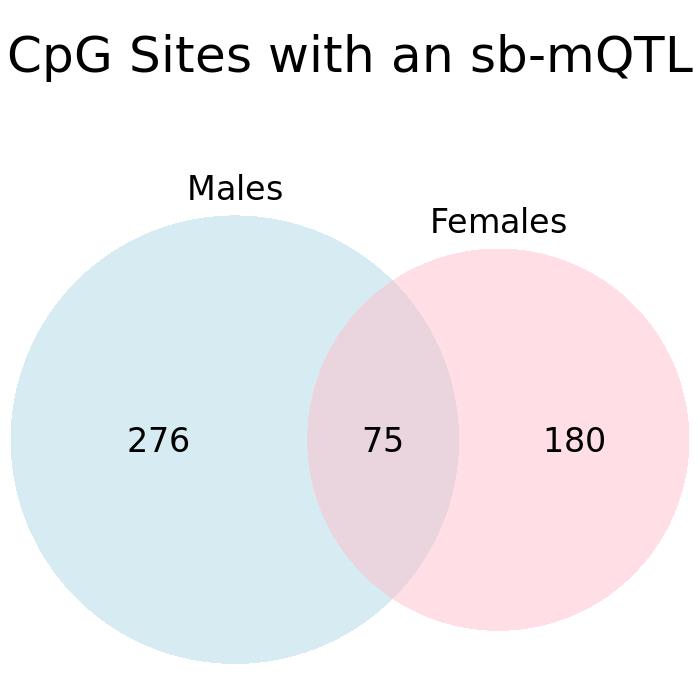

In [60]:
male_int[,.(uniqueN(SNP),uniqueN(Probe),.N)]
female_int[,.(uniqueN(SNP),uniqueN(Probe),.N)]
grid.draw(
    venn.diagram(
        list(Males = unique(male_int$Probe), Females = unique(female_int$Probe)),
        filename=NULL,
        fill=c("light blue", "pink"),
        cat.pos=c(0,0),
        lty = rep("blank",2),
        cex=2,
        cat.cex=2,
        main.cex=3,
        fontfamily= rep("sans-serif",3),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",2),
        main = "CpG Sites with an sb-mQTL"
    )
)

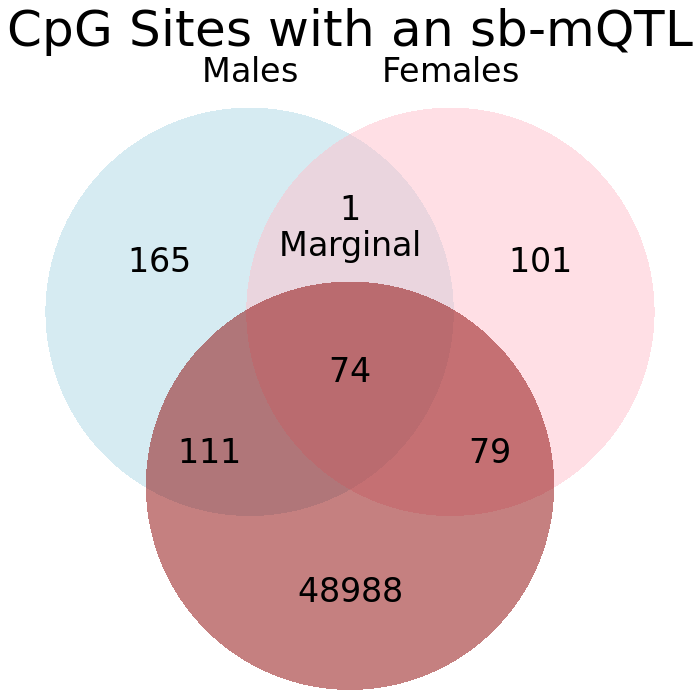

In [62]:
grid.draw(
    venn.diagram(
        list(Males = unique(male_int$Probe), Females = unique(female_int$Probe),Marginal = unique(marginal$Probe)),
        filename=NULL,
        fill=c("light blue", "pink", "dark Red"),
        cat.pos=c(-0,0,0),
        lty = rep("blank",3),
        cex=2,
        cat.cex=2,
        main.cex=3,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "CpG Sites with an sb-mQTL"
    )
)

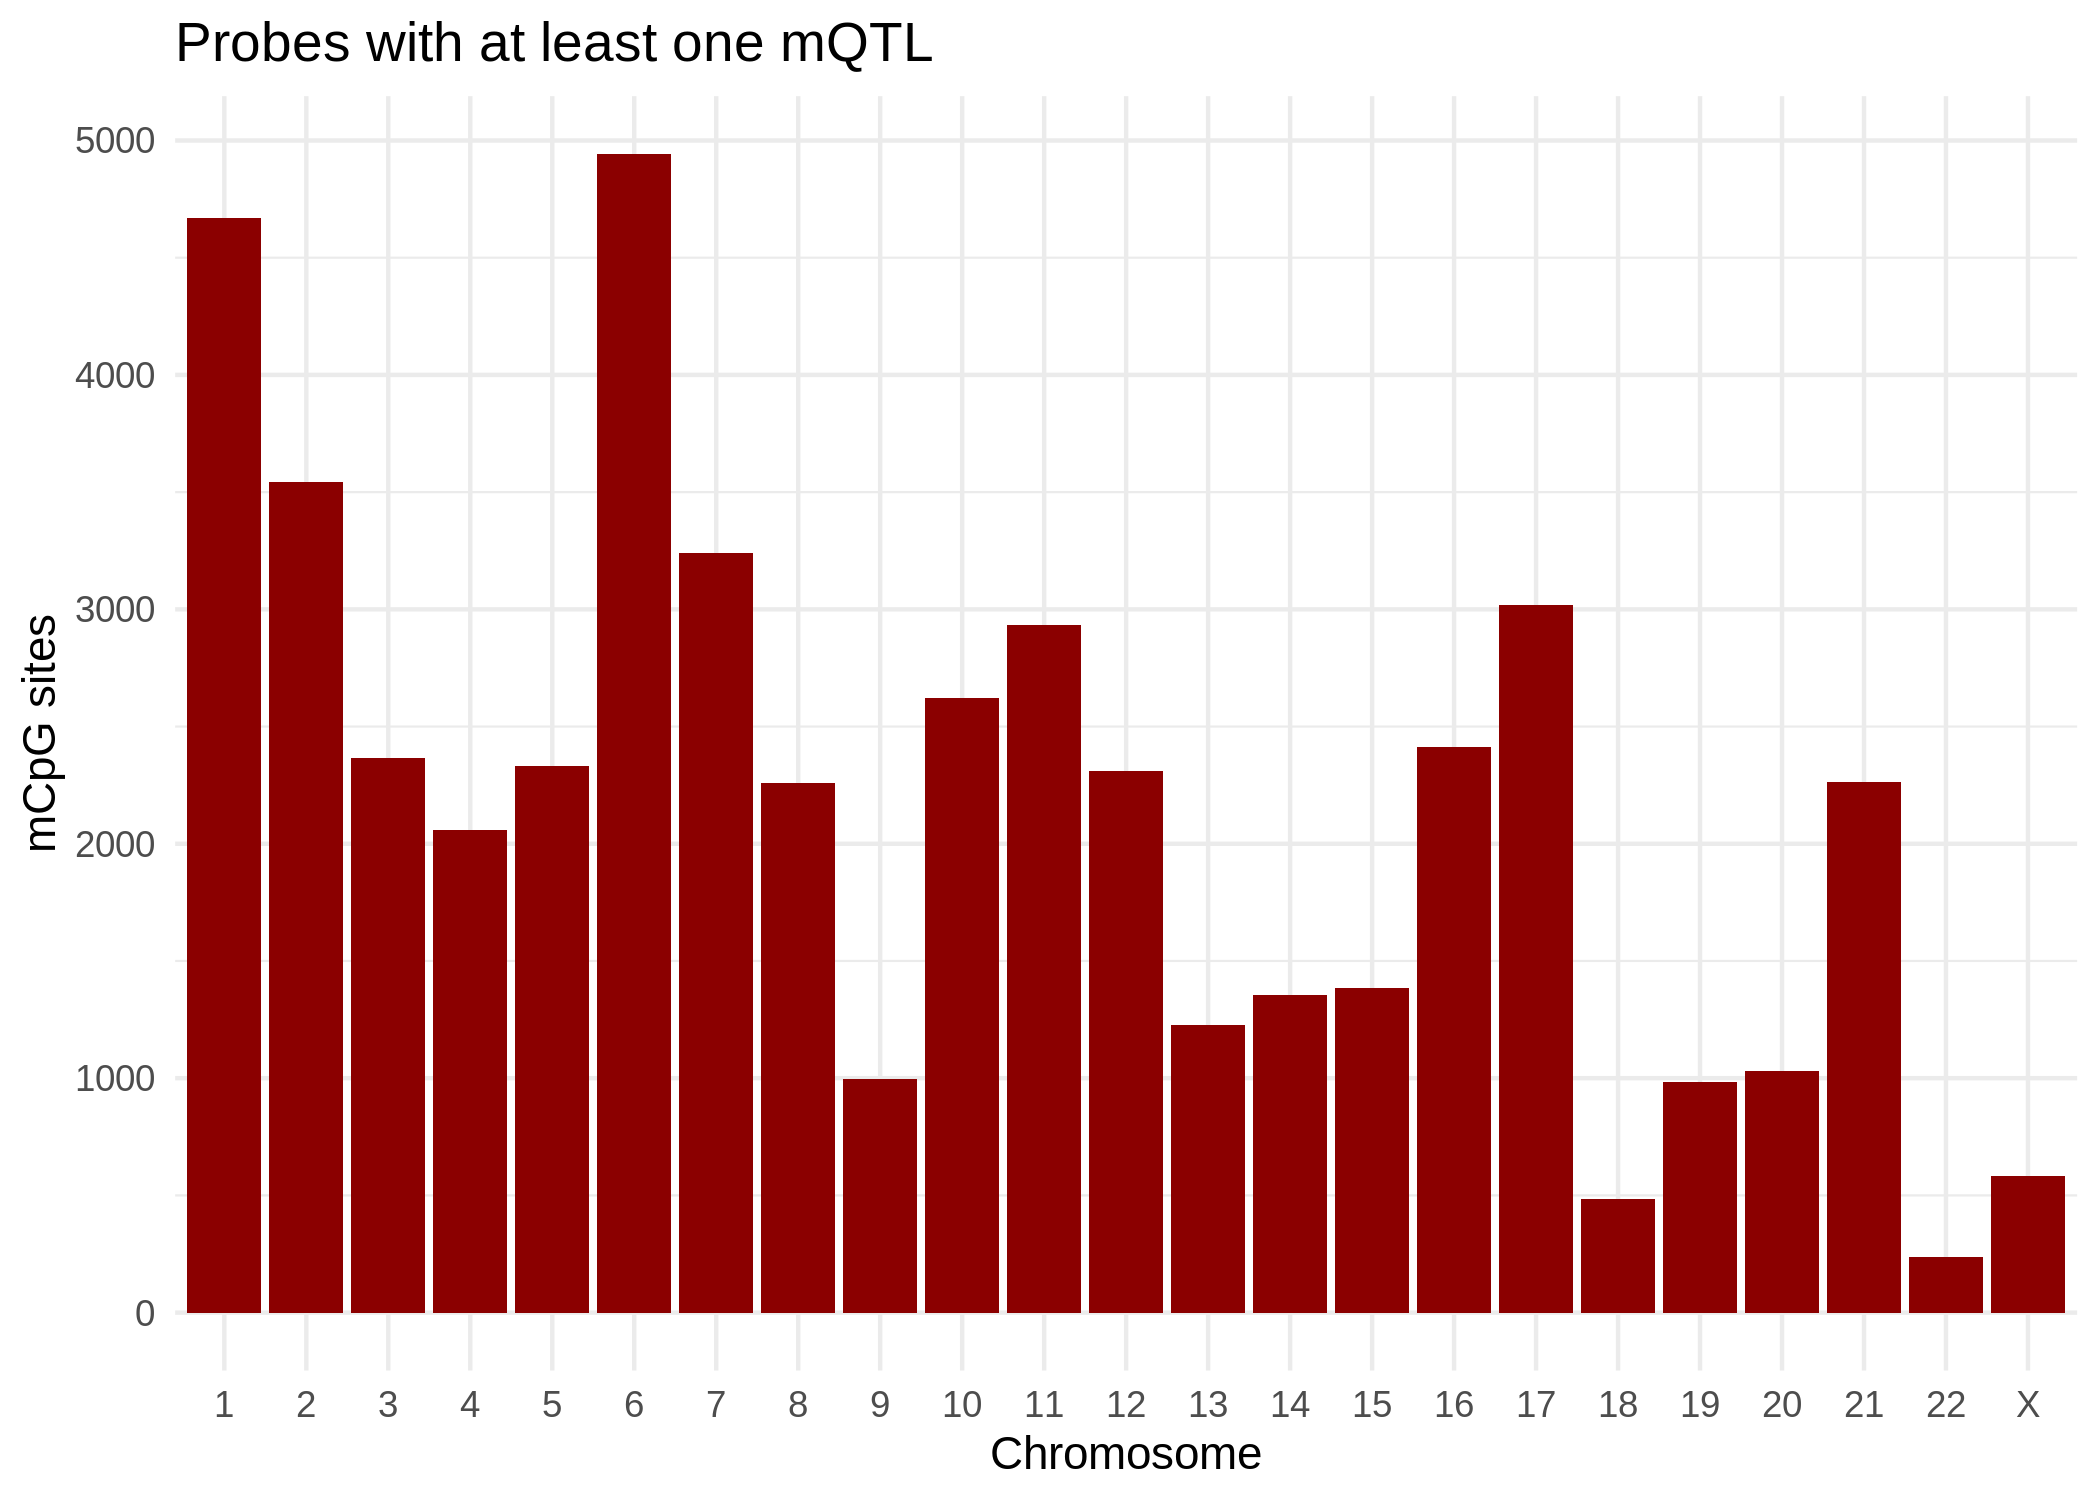

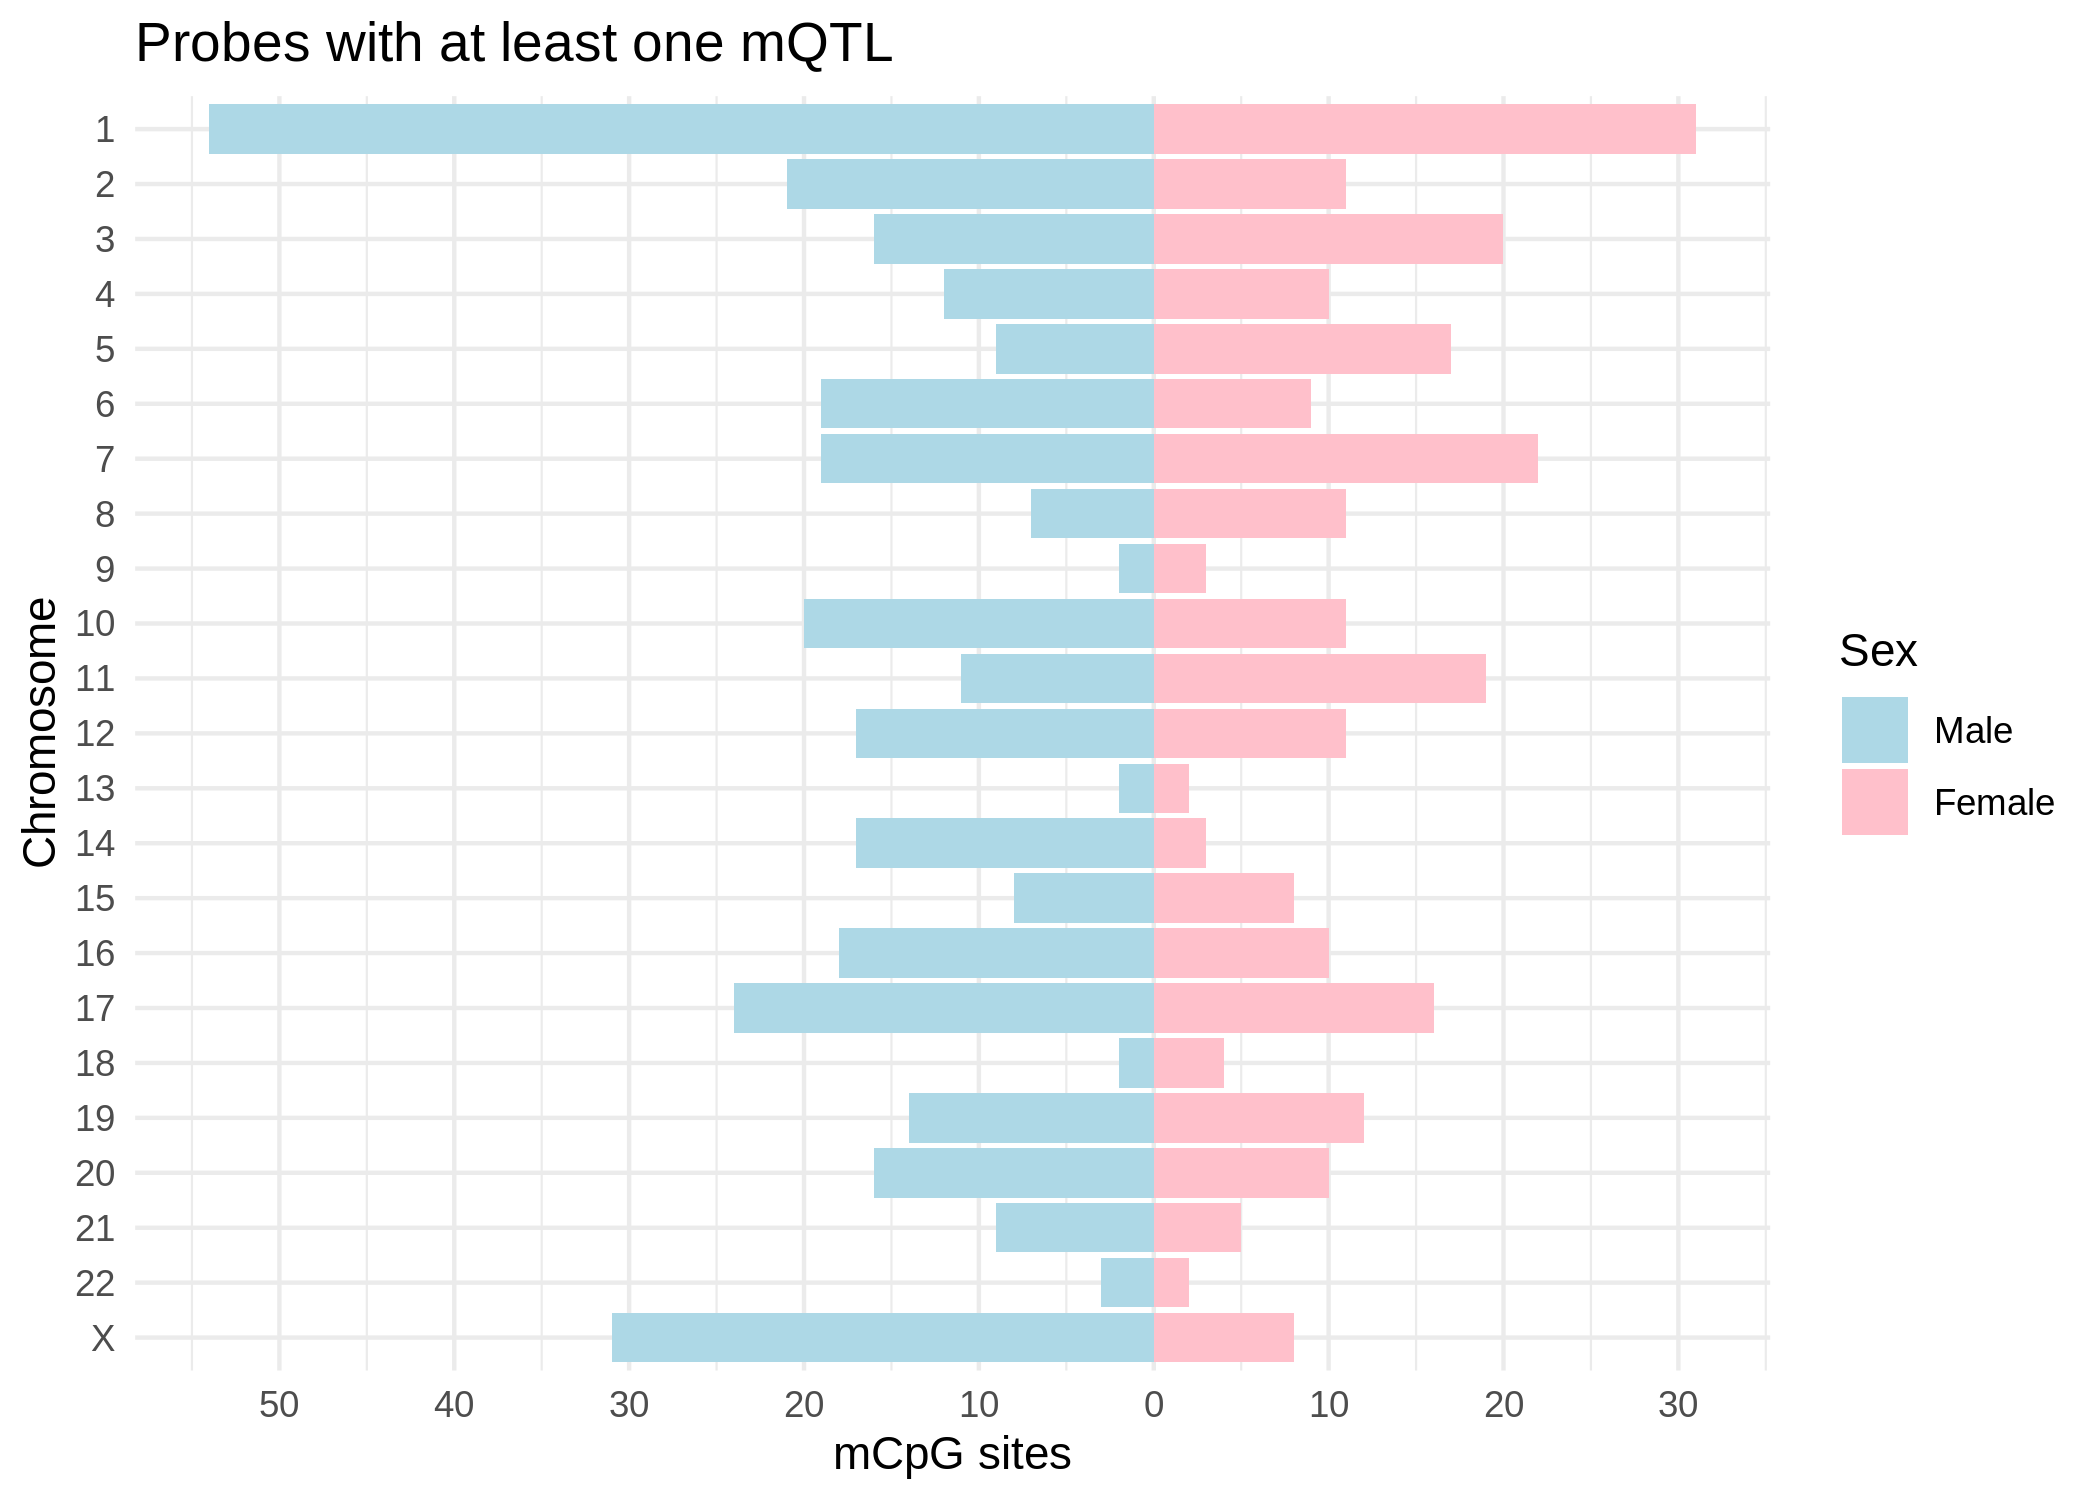

Warning message in cor.test.default(merged_int$b.x, merged_int$b.y, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_sex$b.x, merged_sex$b.y, method = "spearman"):
“Cannot compute exact p-value with ties”


[1] 0

[1] 4.858727e-05

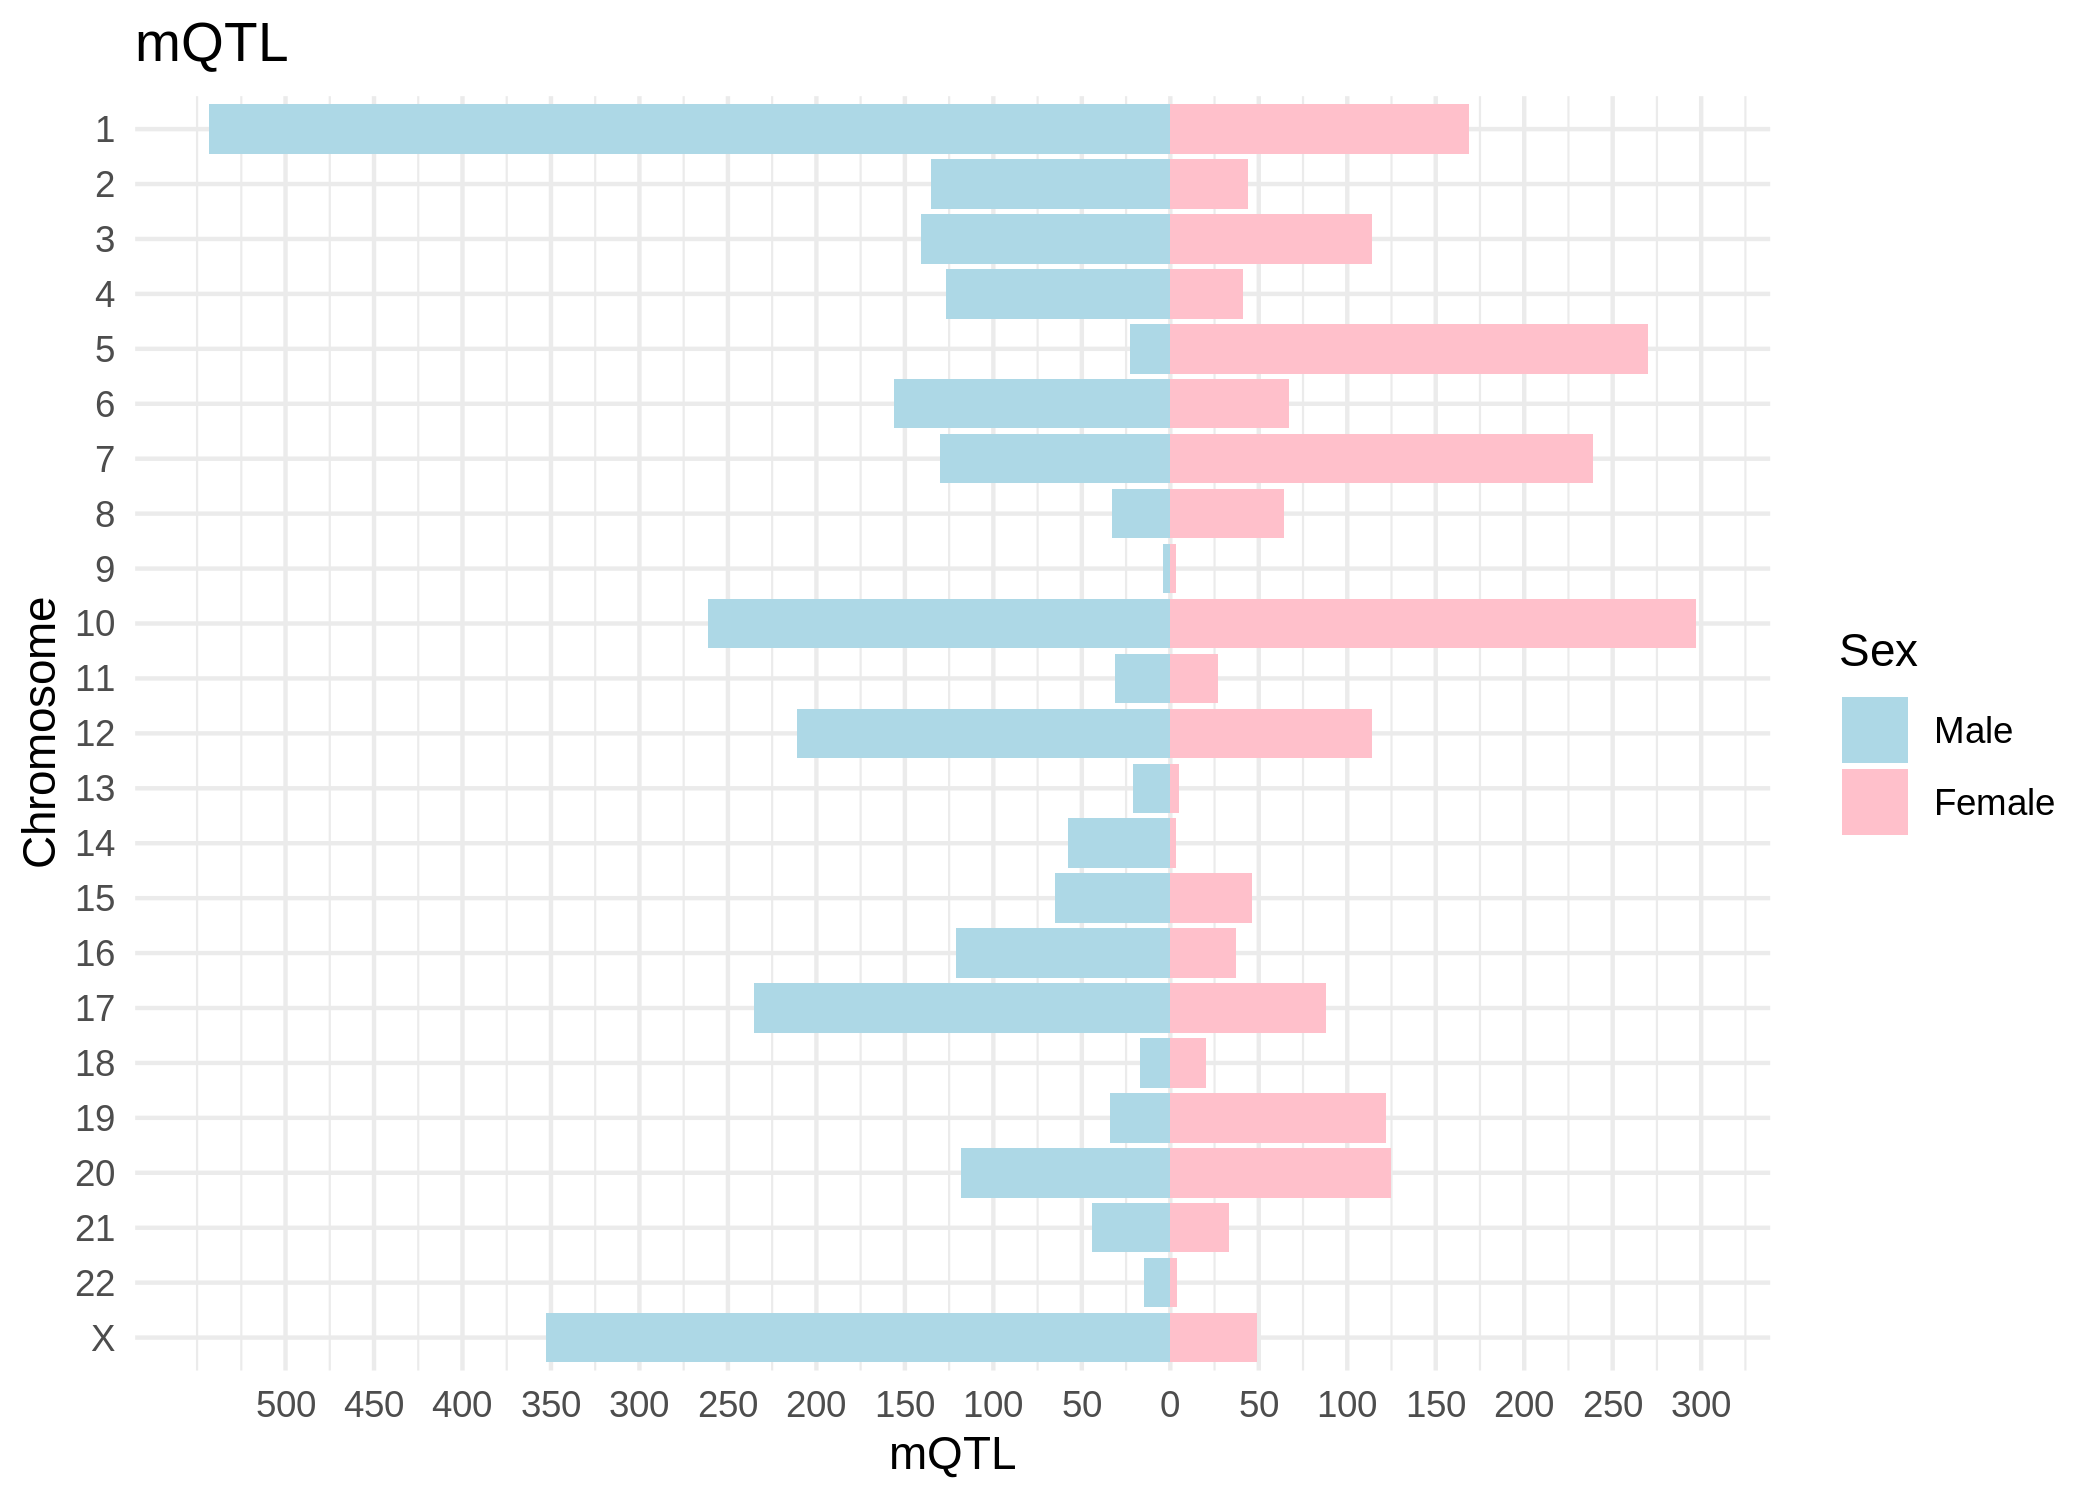

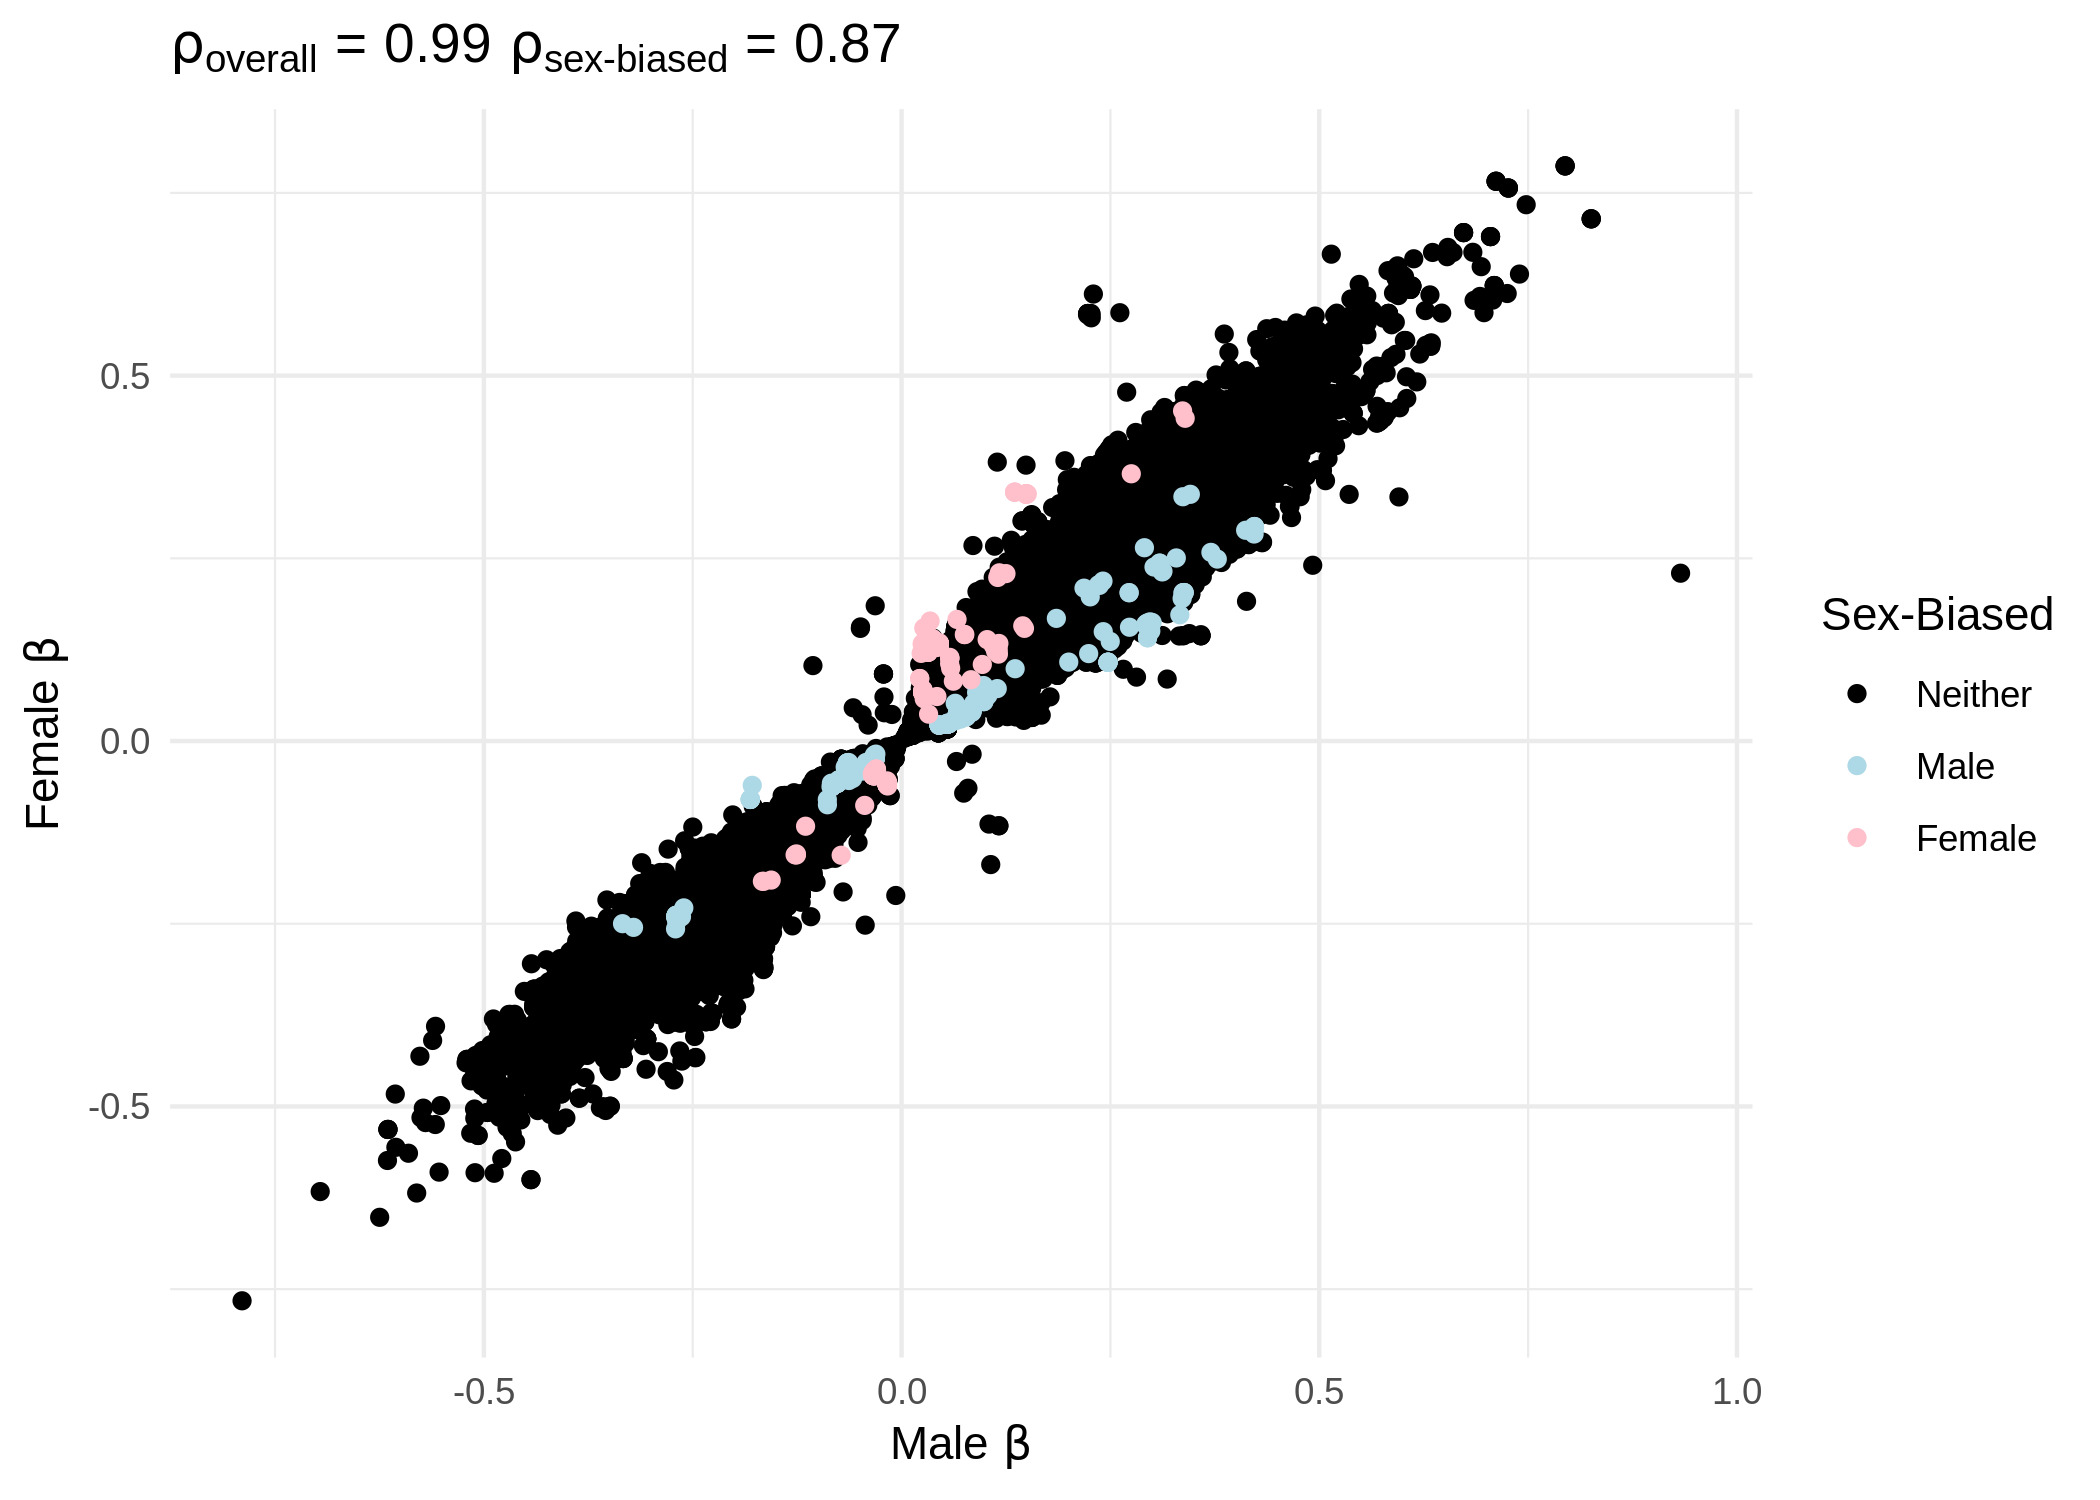

In [70]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
marginal_count_dt <- marginal[,.(nprobe=uniqueN(Probe),mQTL=.N),by="Chr"]
marginal_count_dt$Chr <- factor(c(as.character(1:22),"X"),levels=c(as.character(1:22),"X"))
ggplot(marginal_count_dt,aes(Chr,nprobe))+
    geom_col(fill="dark red") +
    labs(x="Chromosome",y="mCpG sites", title = "Probes with at least one mQTL") +

    theme_minimal()

sex_count_dt <- rbindlist(
    list(male_int[,.(nprobe=-uniqueN(Probe),mQTL = -.N,Sex = "Male"),by="Chr"],female_int[,.(nprobe=uniqueN(Probe),mQTL = .N,Sex="Female"),by="Chr"])
)
sex_effect_dt <- rbindlist(list(male_int[,`:=`(Sex="Male")],female_int[,`:=`(Sex="Female")]))
sex_effect_dt$Chr <- as.character(sex_effect_dt$Chr)
sex_effect_dt$Chr <- factor(ifelse(sex_effect_dt$Chr == "23","X",sex_effect_dt$Chr),levels =c(as.character(1:22),"X"))
sex_effect_dt$Sex <- factor(sex_effect_dt$Sex,levels=c("Male","Female"))
sex_count_dt$Chr <- factor(rep(c(as.character(1:22),"X"),2),levels=rev(c(as.character(1:22),"X")))
sex_count_dt$Sex <- factor(sex_count_dt$Sex,levels=c("Male","Female"))

ggplot(sex_count_dt,aes(Chr,nprobe,fill=Sex)) + 
    geom_col() +
    labs(x="Chromosome",y="mCpG sites", title = "Probes with at least one mQTL") +
    scale_y_continuous(breaks = seq(-50,50,10),labels=c(seq(50,0,-10),seq(10,50,10)))+
    coord_flip() + 
    scale_fill_manual(values=c("light blue", "pink"))+
    theme_minimal()
ggplot(sex_count_dt,aes(Chr,mQTL,fill=Sex)) + 
    geom_col() +
    labs(x="Chromosome",y="mQTL", title = "mQTL") +
    scale_y_continuous(breaks = seq(-500,500,50),labels=c(seq(500,0,-50),seq(50,500,50)))+
    coord_flip() + 
    scale_fill_manual(values=c("light blue", "pink"))+
    theme_minimal()
merged_int <- merge(male_int,female_int, by = c("SNP","Probe"))
merged_sex <- merge(male,female, by = c("SNP","Probe"))
rho_interaction <- cor.test(merged_int$b.x,merged_int$b.y,method="spearman")$estimate
rho_sex <- cor.test(merged_sex$b.x,merged_sex$b.y,method="spearman")$estimate
nrow(merged_int[sign(b.x) != sign(b.y)]) / nrow(merged_int)
nrow(merged_sex[sign(b.x) != sign(b.y)]) / nrow(merged_sex)


ggplot(merged_sex %>%
        mutate(sex_biased = paste0(SNP,Probe) %in% paste0(sex_interaction$SNP,sex_interaction$Probe)) %>%
        mutate(sex_biased = factor(ifelse(sex_biased,ifelse(abs(b.x) > abs(b.y),"Male","Female"),"Neither"), levels = c("Neither","Male","Female"))) %>%arrange(sex_biased),
    aes(b.x,b.y,color=sex_biased) ) + 
    geom_point() +
    labs(
        x=bquote("Male"~beta),
        y=bquote("Female"~beta),color = "Sex-Biased",
        title = bquote(rho["overall"]~"="~.(round(rho_sex,2))~rho["sex-biased"]~"="~.(round(rho_interaction,2))))+
    scale_color_manual(values=c("black","light blue", "pink"))+
    theme_minimal()


Attaching package: ‘ggpubr’


The following object is masked from ‘package:VennDiagram’:

    rotate


Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.

Don't know how to automatically pick scale for object of type noquote. Defaulting to continuous.



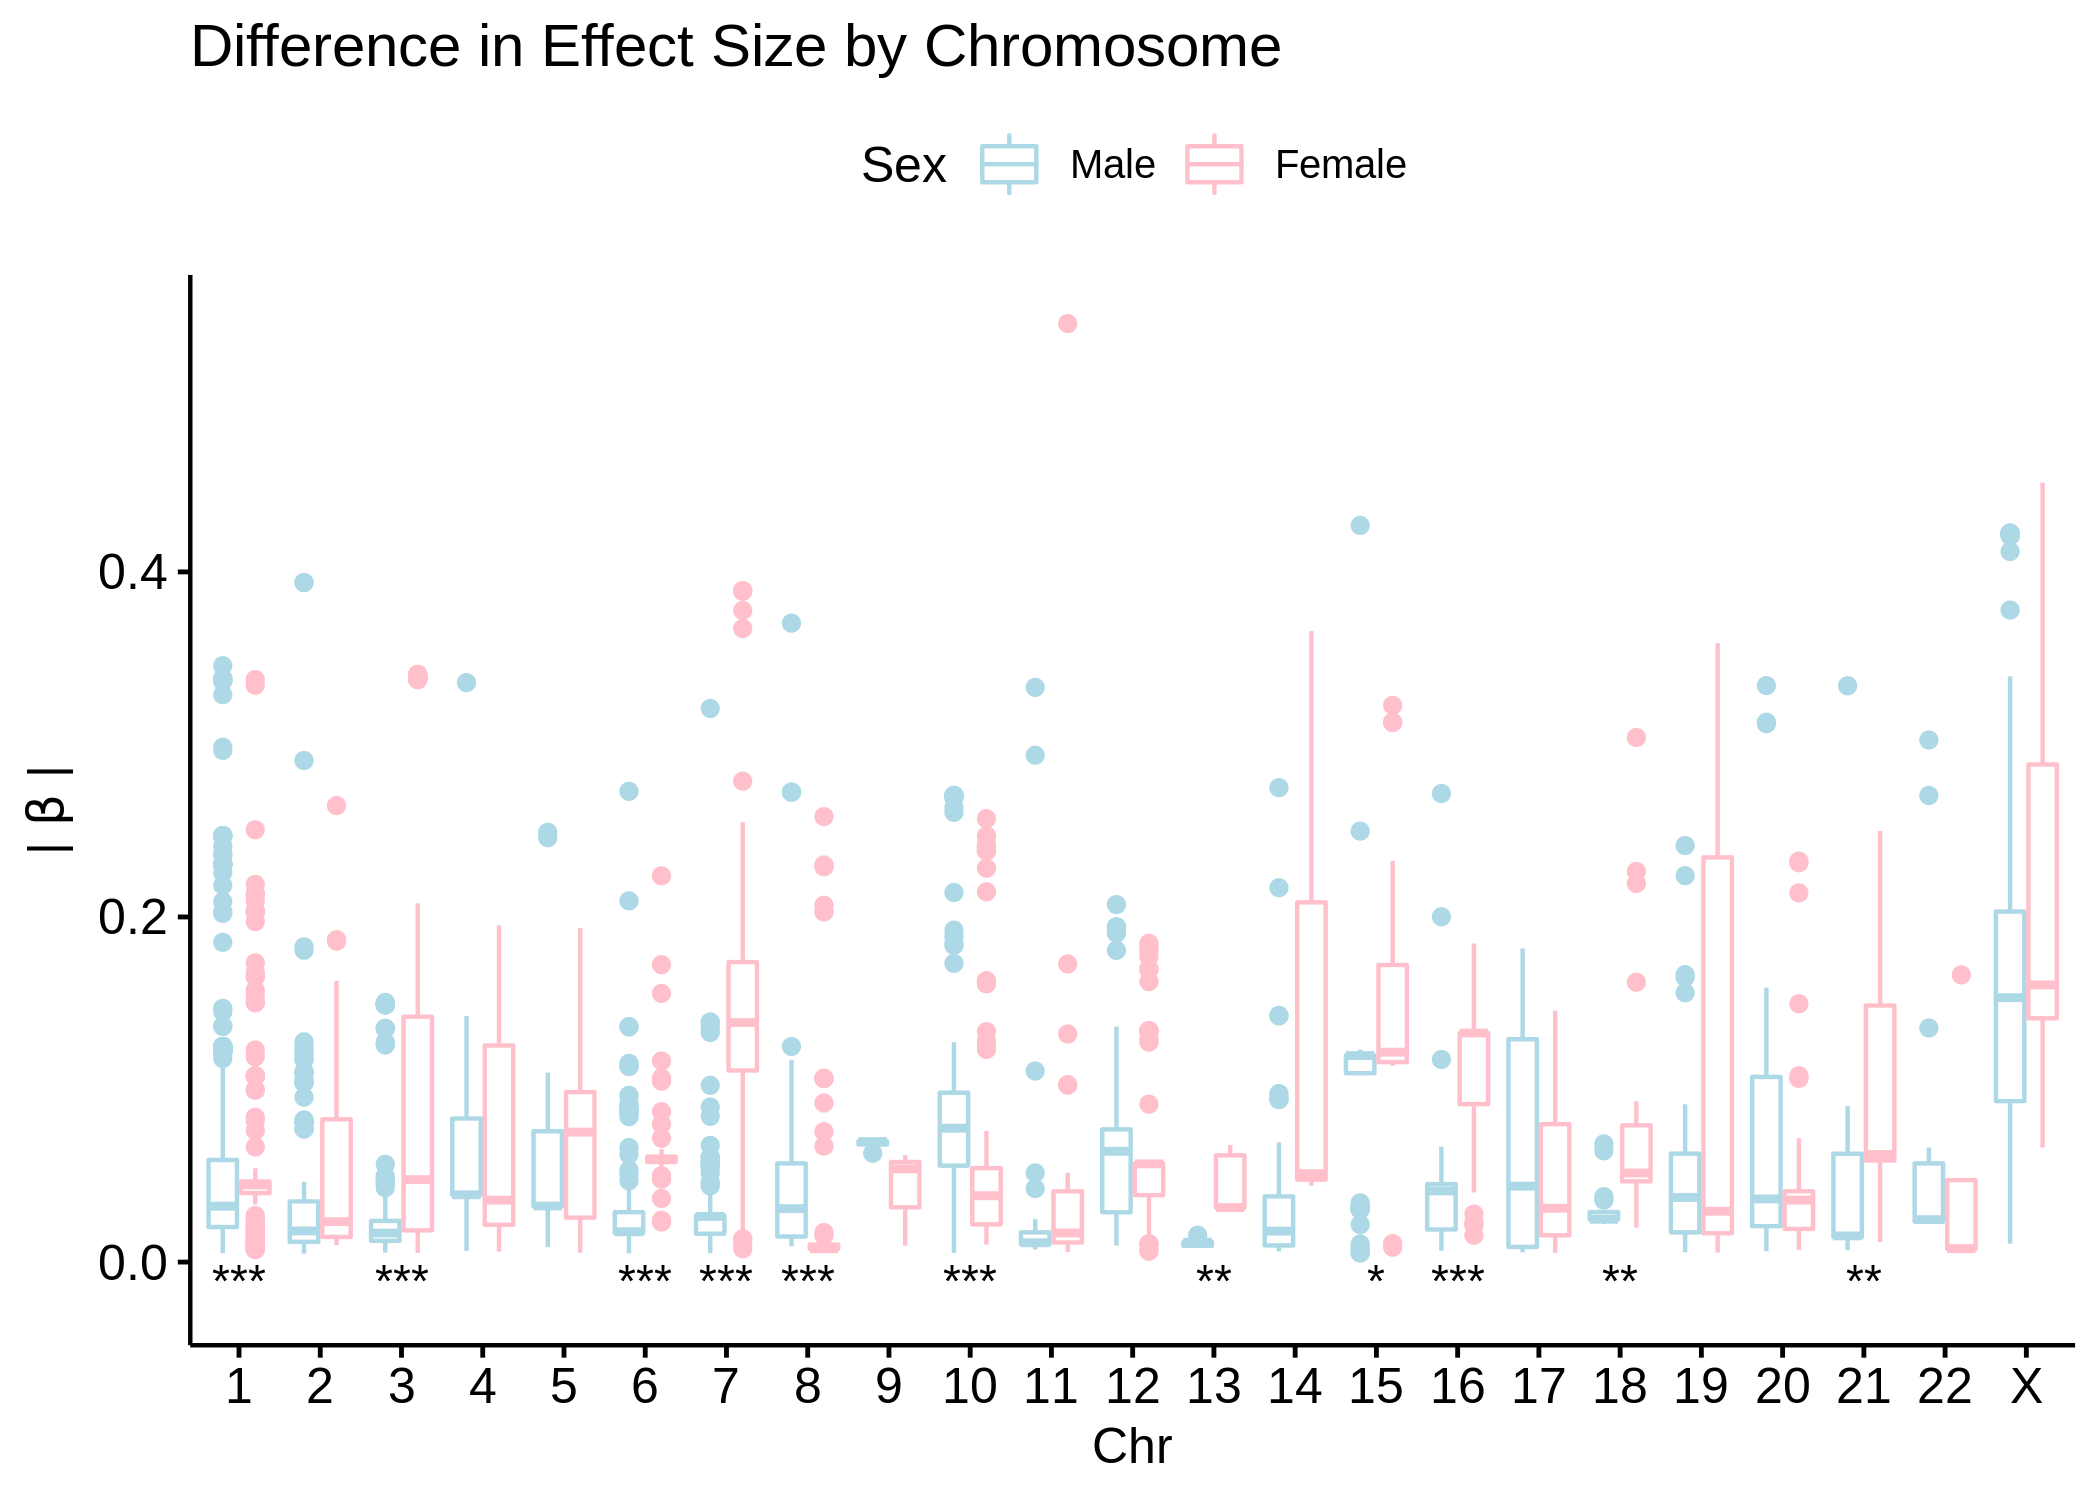

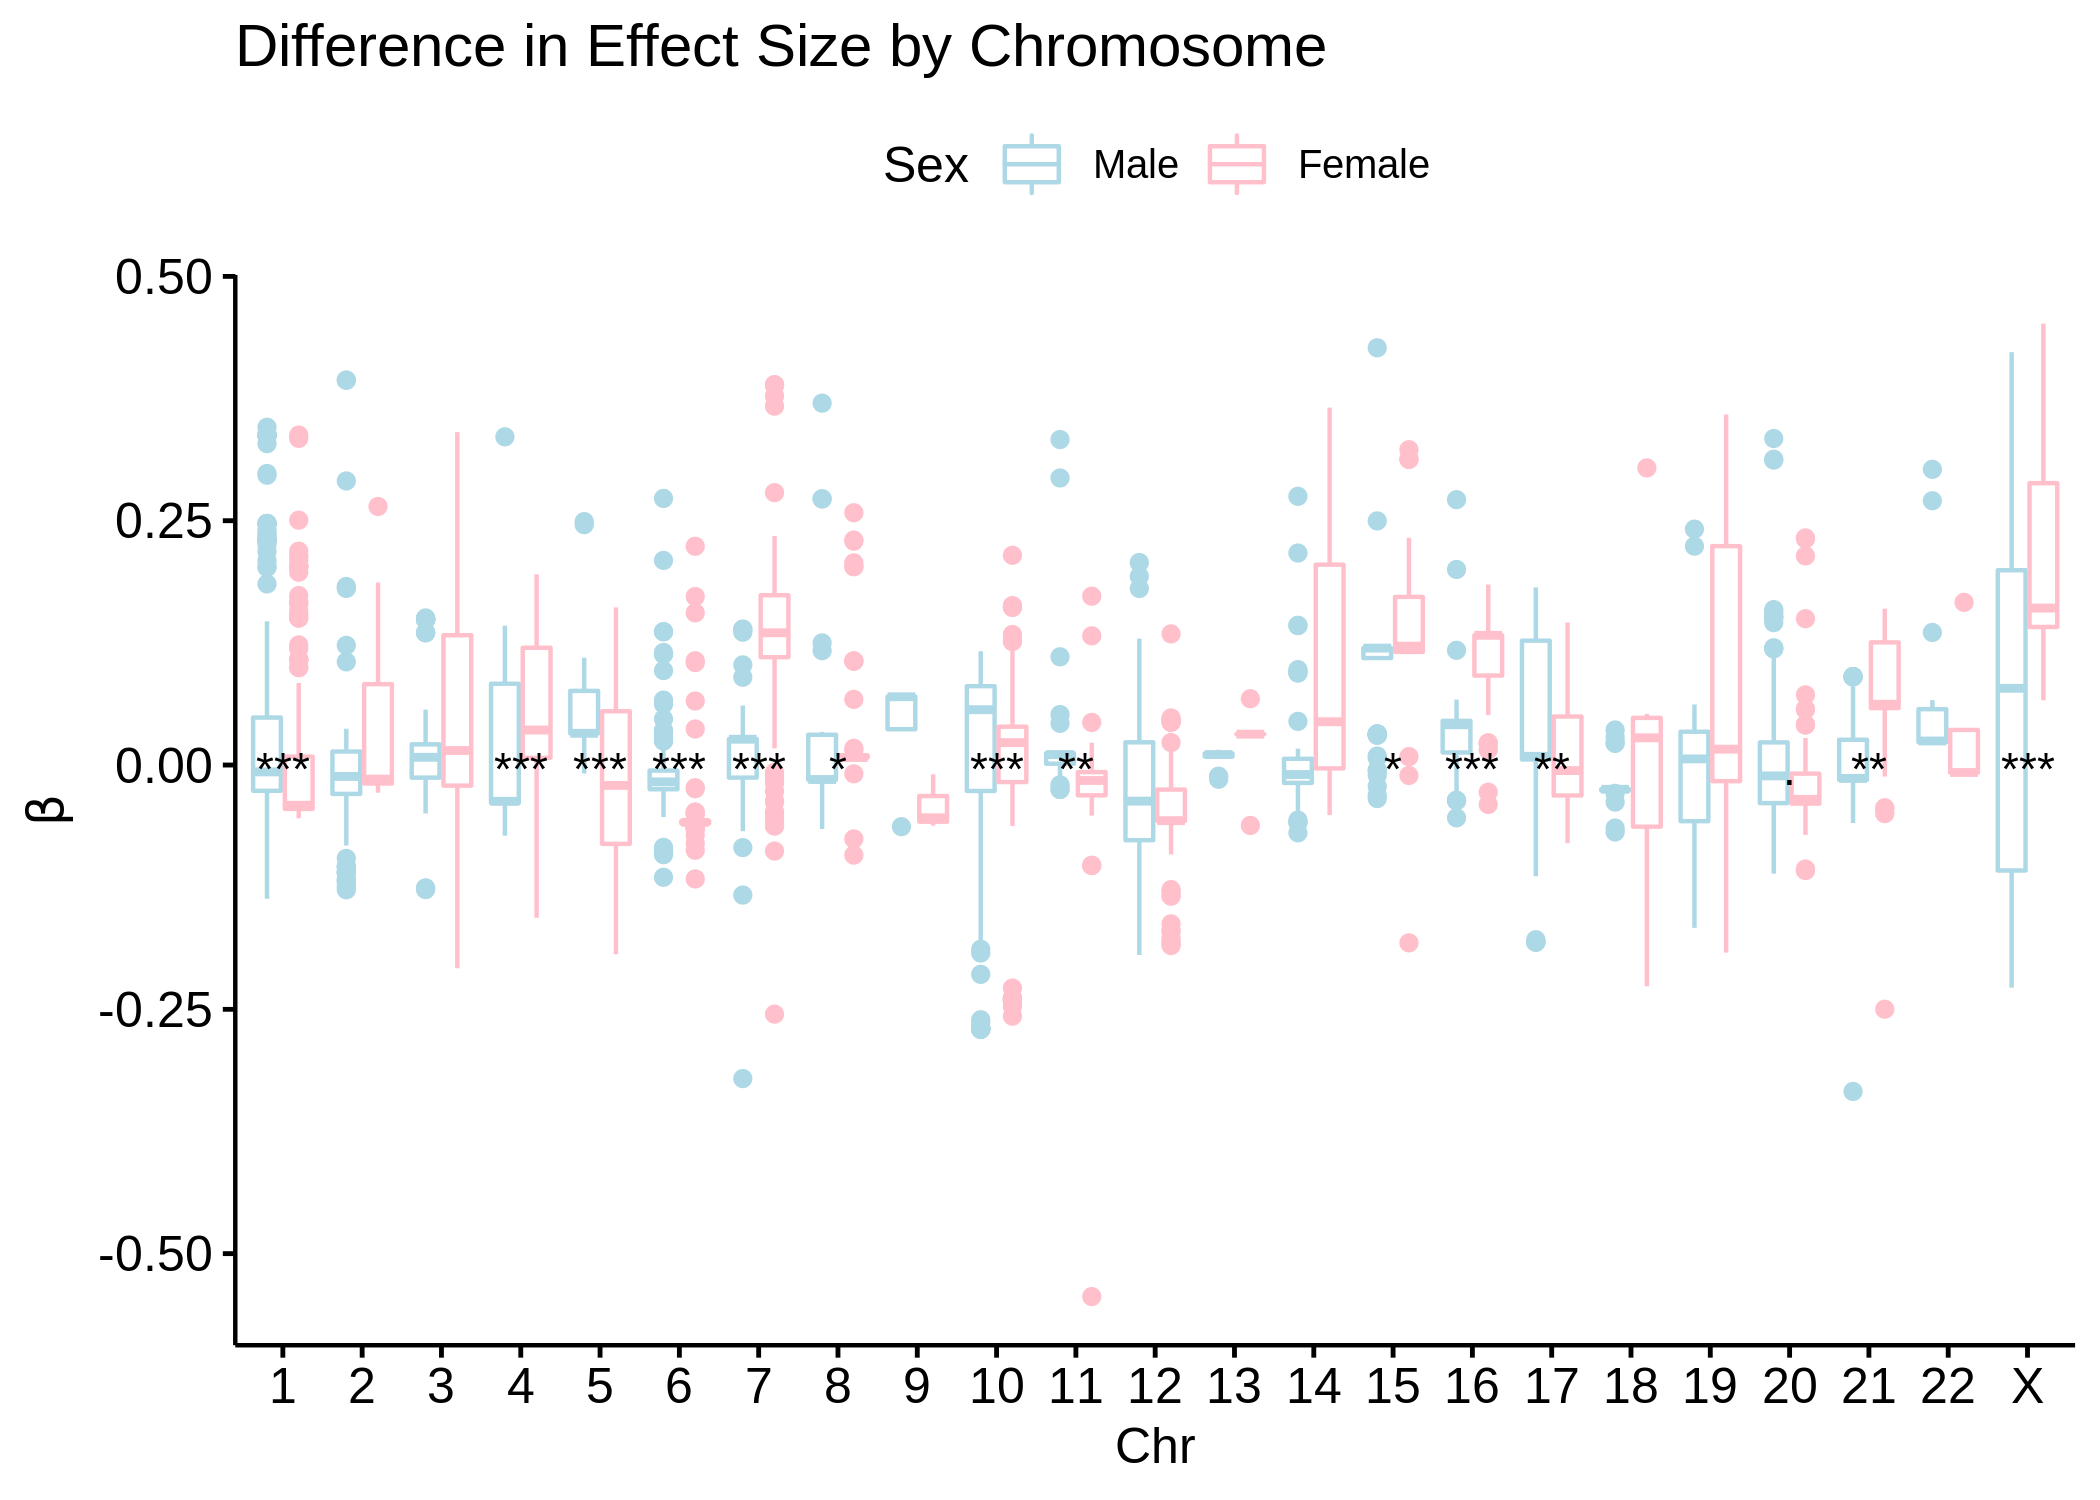

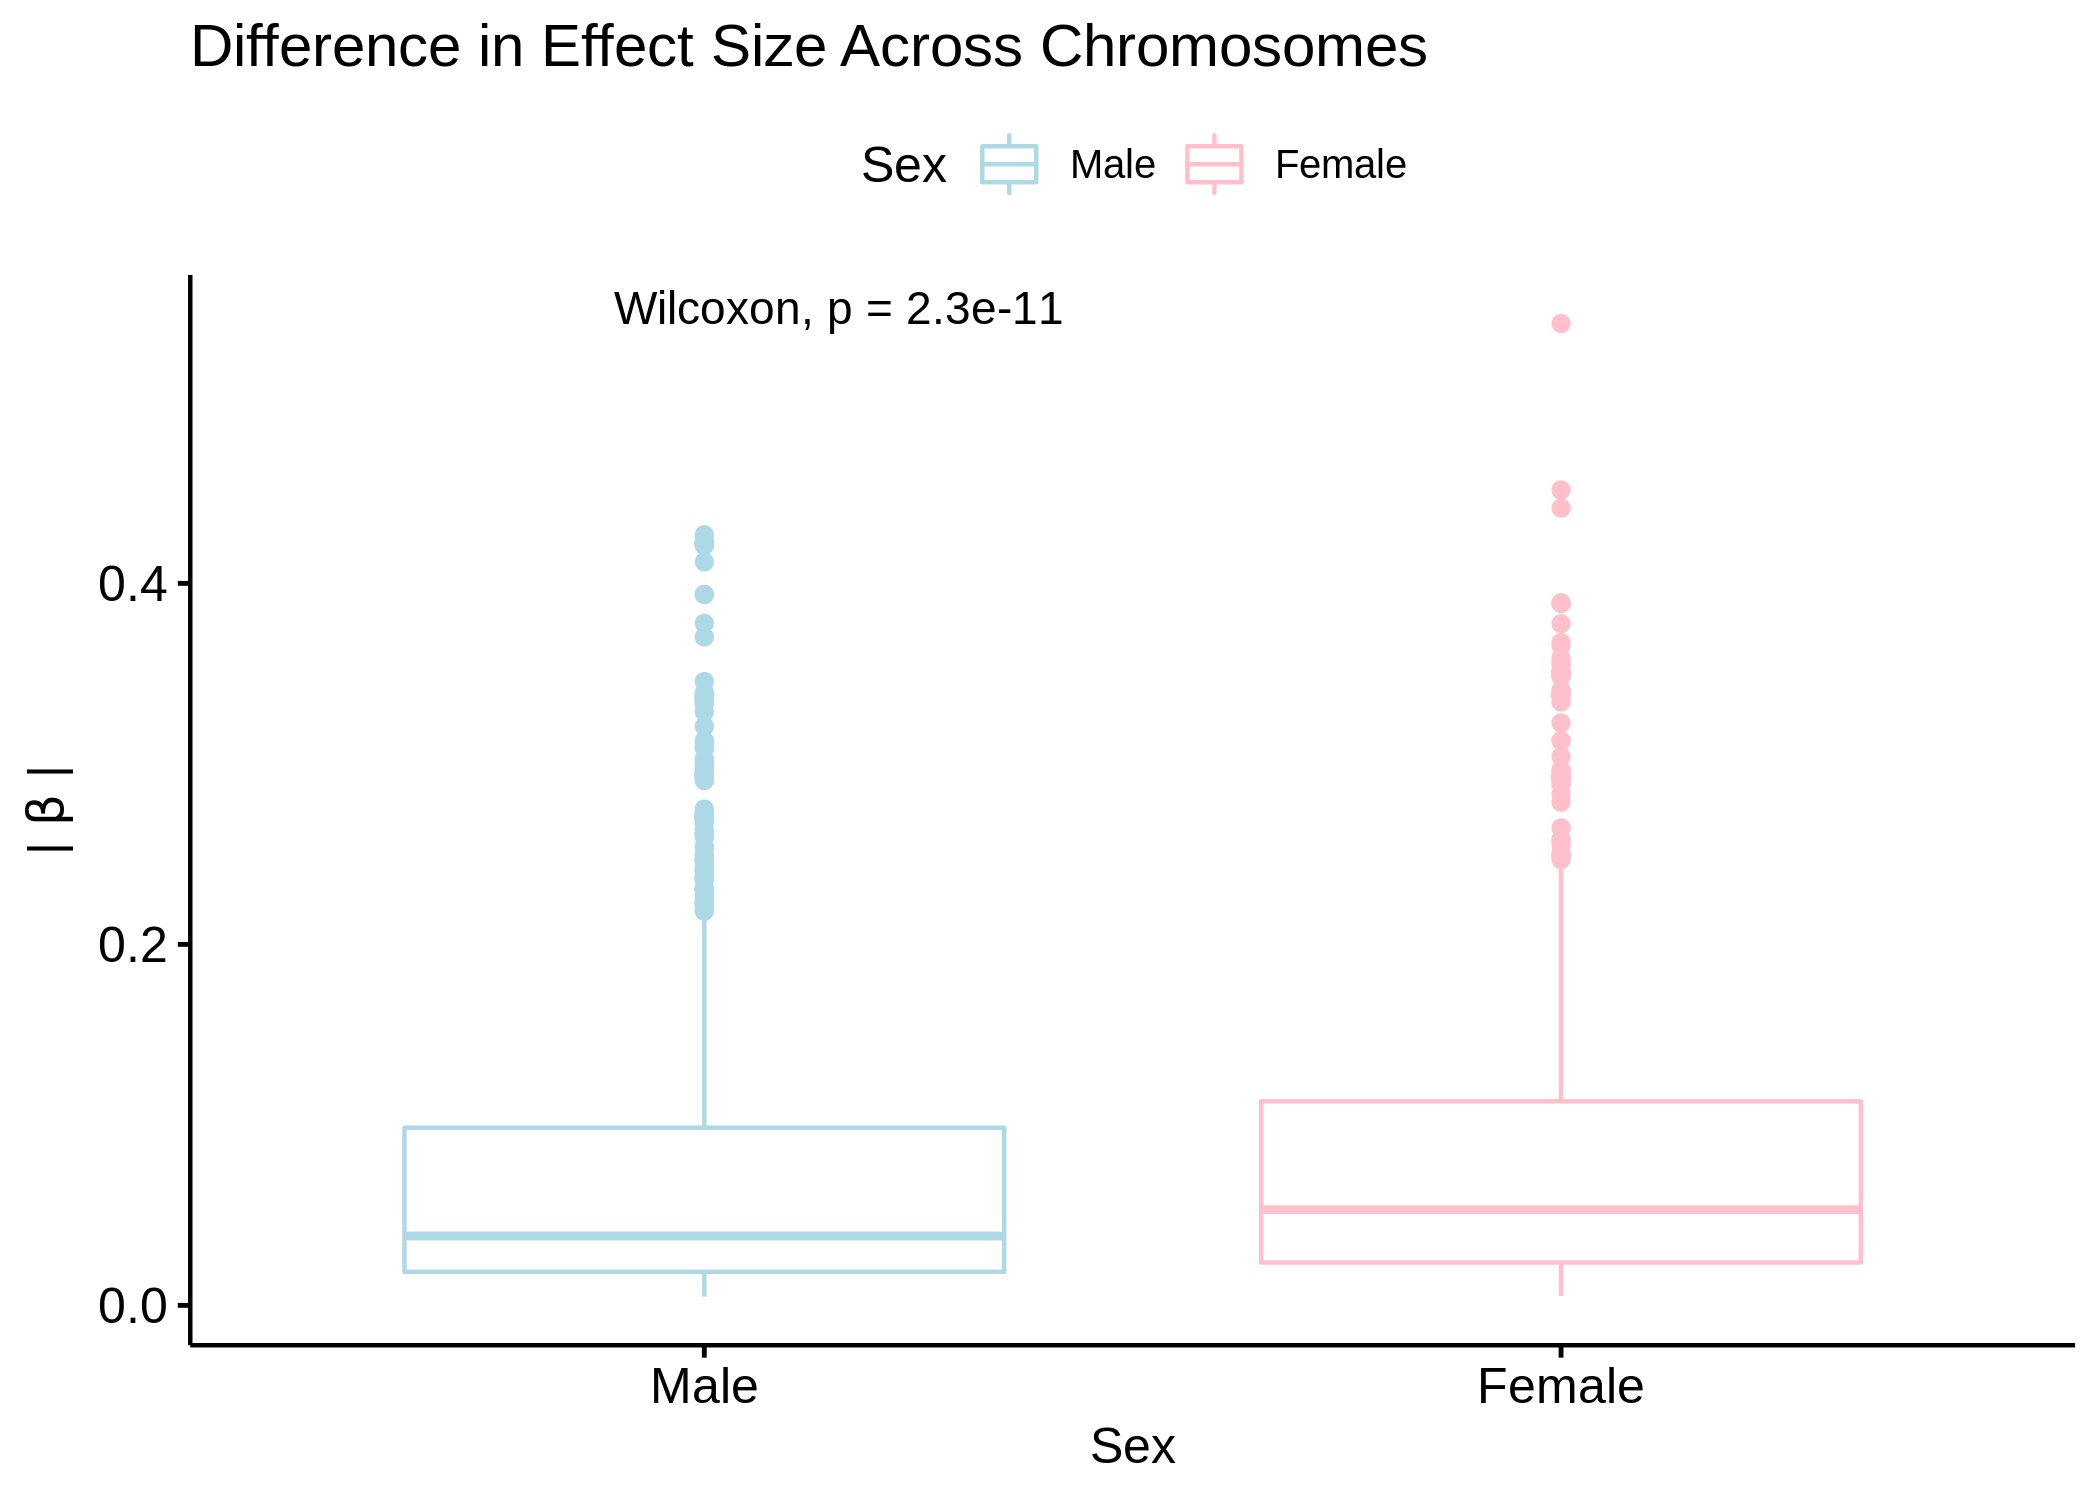

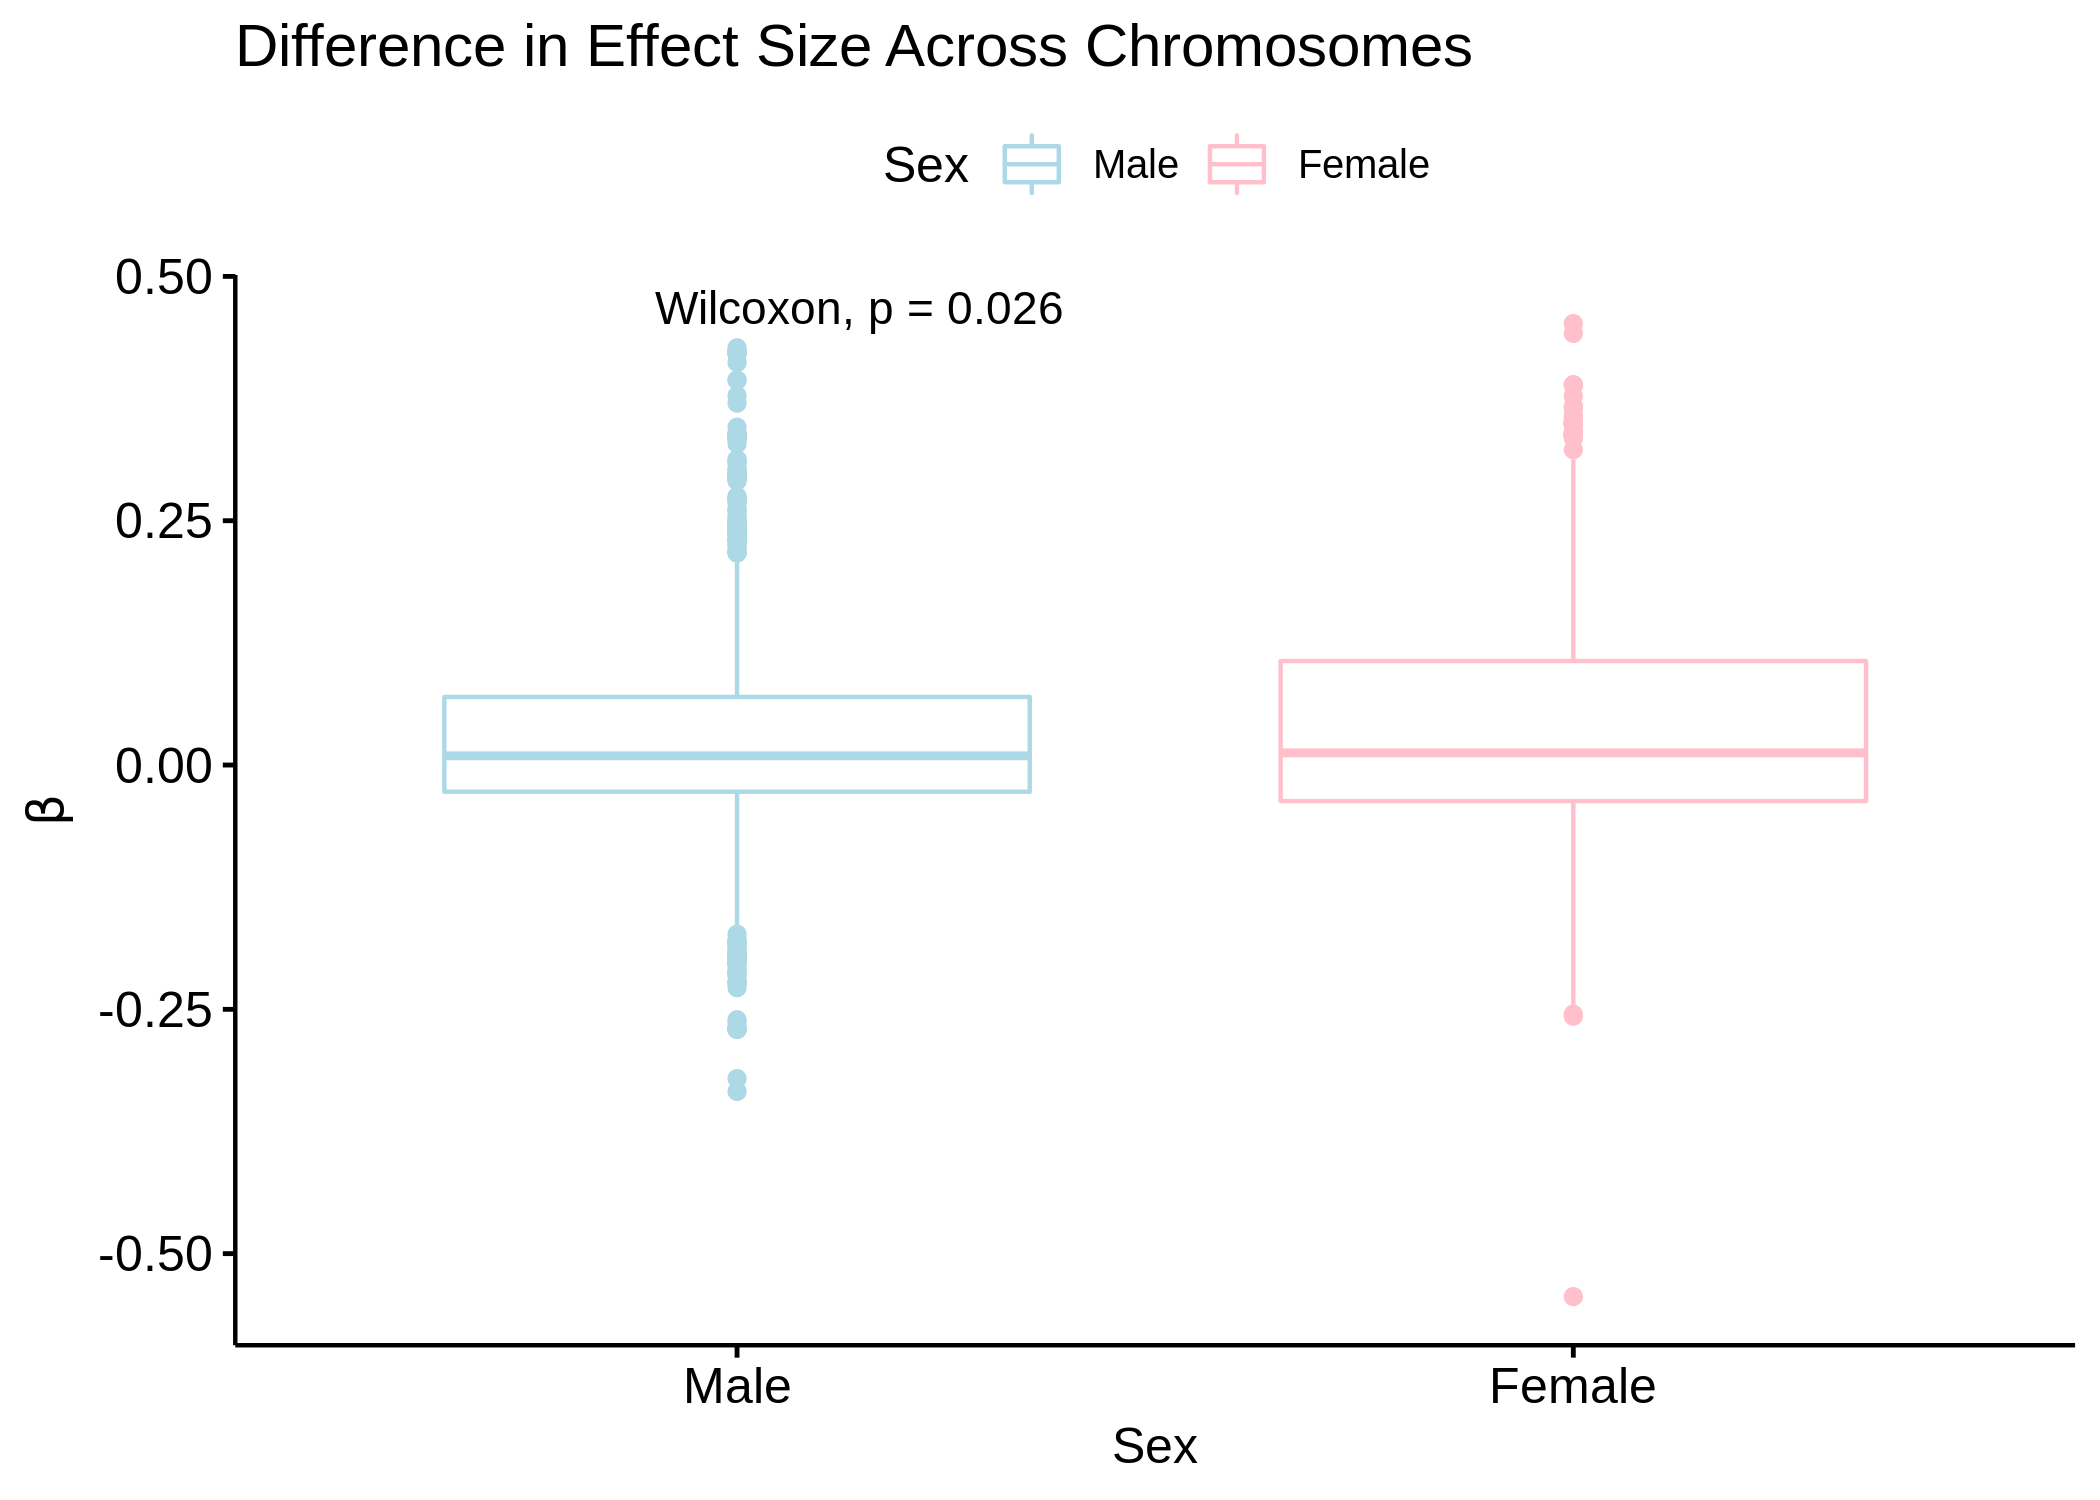

In [6]:
library(ggpubr)
signif.num <- function(x) {
    symnum(x, corr = FALSE, na = FALSE, legend = FALSE,
           cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1), 
           symbols = c("***", "**", "*", ".", " "))
}
ggboxplot(
    sex_effect_dt[,.(Chr,Sex,b=abs(b))],
    x="Chr",
    y='b',
    color="Sex",
    palette=c("light blue", "pink")
) +
    stat_compare_means(aes(group=Sex,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote("|"~beta~"|"), title="Difference in Effect Size by Chromosome")
ggboxplot(
    sex_effect_dt,
    x="Chr",
    y='b',
    color="Sex",
    palette=c("light blue", "pink")
) +
    stat_compare_means(aes(group=Sex,label=signif.num(..p.adj..)),label.y=-0.02,hide.ns = T)+
    labs(y=bquote(beta), title="Difference in Effect Size by Chromosome")


ggboxplot(
    sex_effect_dt[,.(Chr,Sex,b=abs(b))],
    x="Sex",
    y='b',
    color="Sex",
    palette=c("light blue", "pink")
) +
    stat_compare_means()+
    labs(y=bquote("|"~beta~"|"), title="Difference in Effect Size Across Chromosomes")
ggboxplot(
    sex_effect_dt[,.(Chr,Sex,b=b)],
    x="Sex",
    y='b',
    color="Sex",
    palette=c("light blue", "pink")
) +
    stat_compare_means()+
    labs(y=bquote(beta), title="Difference in Effect Size Across Chromosomes")

In [7]:
compare_means(b~Sex,sex_effect_dt, group.by = "Chr")
compare_means(b~Sex,sex_effect_dt[,.(Chr,Sex,b=abs(b))], group.by = "Chr")
compare_means(b~Sex,sex_effect_dt[,.(Chr,Sex,b)])
compare_means(b~Sex,sex_effect_dt[,.(Chr,Sex,b=abs(b))])

Chr,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,b,Male,Female,6.479045e-13,1.4e-11,6.5e-13,****,Wilcoxon
2,b,Male,Female,1.119149e-01,6.9e-01,0.11191,ns,Wilcoxon
3,b,Male,Female,1.179544e-01,6.9e-01,0.11795,ns,Wilcoxon
4,b,Male,Female,6.618751e-06,1.2e-04,6.6e-06,****,Wilcoxon
5,b,Male,Female,4.449510e-05,7.1e-04,4.4e-05,****,Wilcoxon
6,b,Male,Female,6.057615e-16,1.3e-14,6.1e-16,****,Wilcoxon
7,b,Male,Female,4.207711e-41,9.7e-40,< 2e-16,****,Wilcoxon
8,b,Male,Female,3.167652e-03,3.8e-02,0.00317,**,Wilcoxon
9,b,Male,Female,3.724559e-01,1.0e+00,0.37246,ns,Wilcoxon


Chr,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,b,Male,Female,2.575834e-05,4.4e-04,2.6e-05,****,Wilcoxon
2,b,Male,Female,3.524194e-02,3.9e-01,0.03524,*,Wilcoxon
3,b,Male,Female,2.014933e-08,3.8e-07,2.0e-08,****,Wilcoxon
4,b,Male,Female,4.921341e-01,9.8e-01,0.49213,ns,Wilcoxon
5,b,Male,Female,2.367376e-01,7.1e-01,0.23674,ns,Wilcoxon
6,b,Male,Female,2.996243e-19,6.3e-18,< 2e-16,****,Wilcoxon
7,b,Male,Female,1.256535e-45,2.9e-44,< 2e-16,****,Wilcoxon
8,b,Male,Female,3.157975e-07,5.7e-06,3.2e-07,****,Wilcoxon
9,b,Male,Female,4.974599e-02,4.7e-01,0.04975,*,Wilcoxon


.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
b,Male,Female,0.02605251,0.026,0.026,*,Wilcoxon


.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
b,Male,Female,2.303366e-11,2.3e-11,2.3e-11,****,Wilcoxon


In [8]:
sex_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Chr","Sex")]
sex_effect_dt[,.(mean_beta=mean(b),mean_abs_beta=mean(abs(b))),by=c("Sex")]

Chr,Sex,mean_beta,mean_abs_beta
<fct>,<fct>,<dbl>,<dbl>
1,Male,0.023547942,0.05581791
2,Male,-0.006875808,0.04218298
3,Male,0.016887115,0.03558615
4,Male,0.014247370,0.05694747
5,Male,0.061357723,0.06210697
6,Male,-0.007567177,0.03156349
7,Male,0.012789878,0.03330692
8,Male,0.021262047,0.05901179
9,Male,0.036752875,0.06829347


Sex,mean_beta,mean_abs_beta
<fct>,<dbl>,<dbl>
Male,0.02149235,0.06809077
Female,0.03464848,0.07904171


## Counting CpG sites


In [3]:
array_annot < -fread("/scratch/st-dennisjk-1/wcasazza/450k_annotation.csv")
head(array_annot[chr == "chr1"])

V1,chr,pos,strand,Name,AddressA,AddressB,ProbeSeqA,ProbeSeqB,Type,⋯,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<lgl>
cg00000957,chr1,5937253,+,cg00000957,65648367,36743439,ATACTACTAACCCATACCCAACAAAACAAAAAACCCCAAAACATCAACCA,ATACTACTAACCCATACCCGACAAAACAAAAAACCCCAAAACGTCAACCG,I,⋯,NPHP4,NM_015102,Body,,,NA,1:5859745-5859915,1:5937082-5937731,Unclassified_Cell_type_specific,NA
cg00001349,chr1,166958439,-,cg00001349,11722421,53758324,CAAAACAACACAAACCAAAATCTTCCAATCTCAAACTATTTATTCCCCCA,CAAAACGACACGAACCGAAATCTTCCAATCTCAAACTATTTATTCCCCCG,I,⋯,MAEL,NM_032858,TSS200,,,NA,1:165224845-165225561,,,NA
cg00001583,chr1,200011786,-,cg00001583,55630379,24638471,ACAAAAAATAAAACCTAAACAAAAACCTAATACACCCACAAATTTCACCA,ACAAAAAATAAAACCTAAACGAAAACCTAATACGCCCACGAATTTCGCCG,I,⋯,NR5A2;NR5A2,NM_205860;NM_003822,Body;Body,,,NA,1:198278176-198278678,,,NA
cg00002028,chr1,20960010,-,cg00002028,56738397,74621430,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAACAACA,CCCAAATTTATTATAACCGACGAAAAACGCCGATAATAACGACAACGACG,I,⋯,PINK1;PINK1,NM_032409;NM_032409,1stExon;5'UTR,high-CpG:20832533-20832876,,NA,1:20832399-20833138,1:20959206-20960060,Promoter_Associated,NA
cg00002719,chr1,169396706,+,cg00002719,52741444,27736432,CAATAATCTAAAAATATTACATACACCTACACAAATTTTTATCACTCTCA,CGATAATCTAAAAATATTACATACGCCTACGCAAATTTTTATCGCTCTCG,I,⋯,C1orf114,NM_021179,TSS200,,,TRUE,1:167663071-167663470,,,NA
cg00002837,chr1,44513358,-,cg00002837,45703447,25764310,ATCATAAAAACATCCTACCCTAAAACCAAAAATTTAAAAATAAAAACACA,ATCGTAAAAACATCCTACCCTAAAACCAAAAATTTAAAAATAAAAACACG,I,⋯,,,,,,NA,,1:44512719-44514060,Unclassified,TRUE


In [10]:
annotated_dt_sex <- sex_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]
annotated_dt_marginal <- marginal[array_annot,on=c("Probe"="Name"),nomatch=0]
annotated_dt_sex$Sex <- "Both Sexes"
annotated_dt_marginal$Sex <- "Marginal"
total_annotated <- rbindlist(list(annotated_dt_sex,annotated_dt_marginal,sex_effect_dt[array_annot,on=c("Probe"="Name"),nomatch=0]),fill=TRUE)
total_annotated$Sex <- factor(total_annotated$Sex,levels=c("Male","Female","Both Sexes", "Marginal"))

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



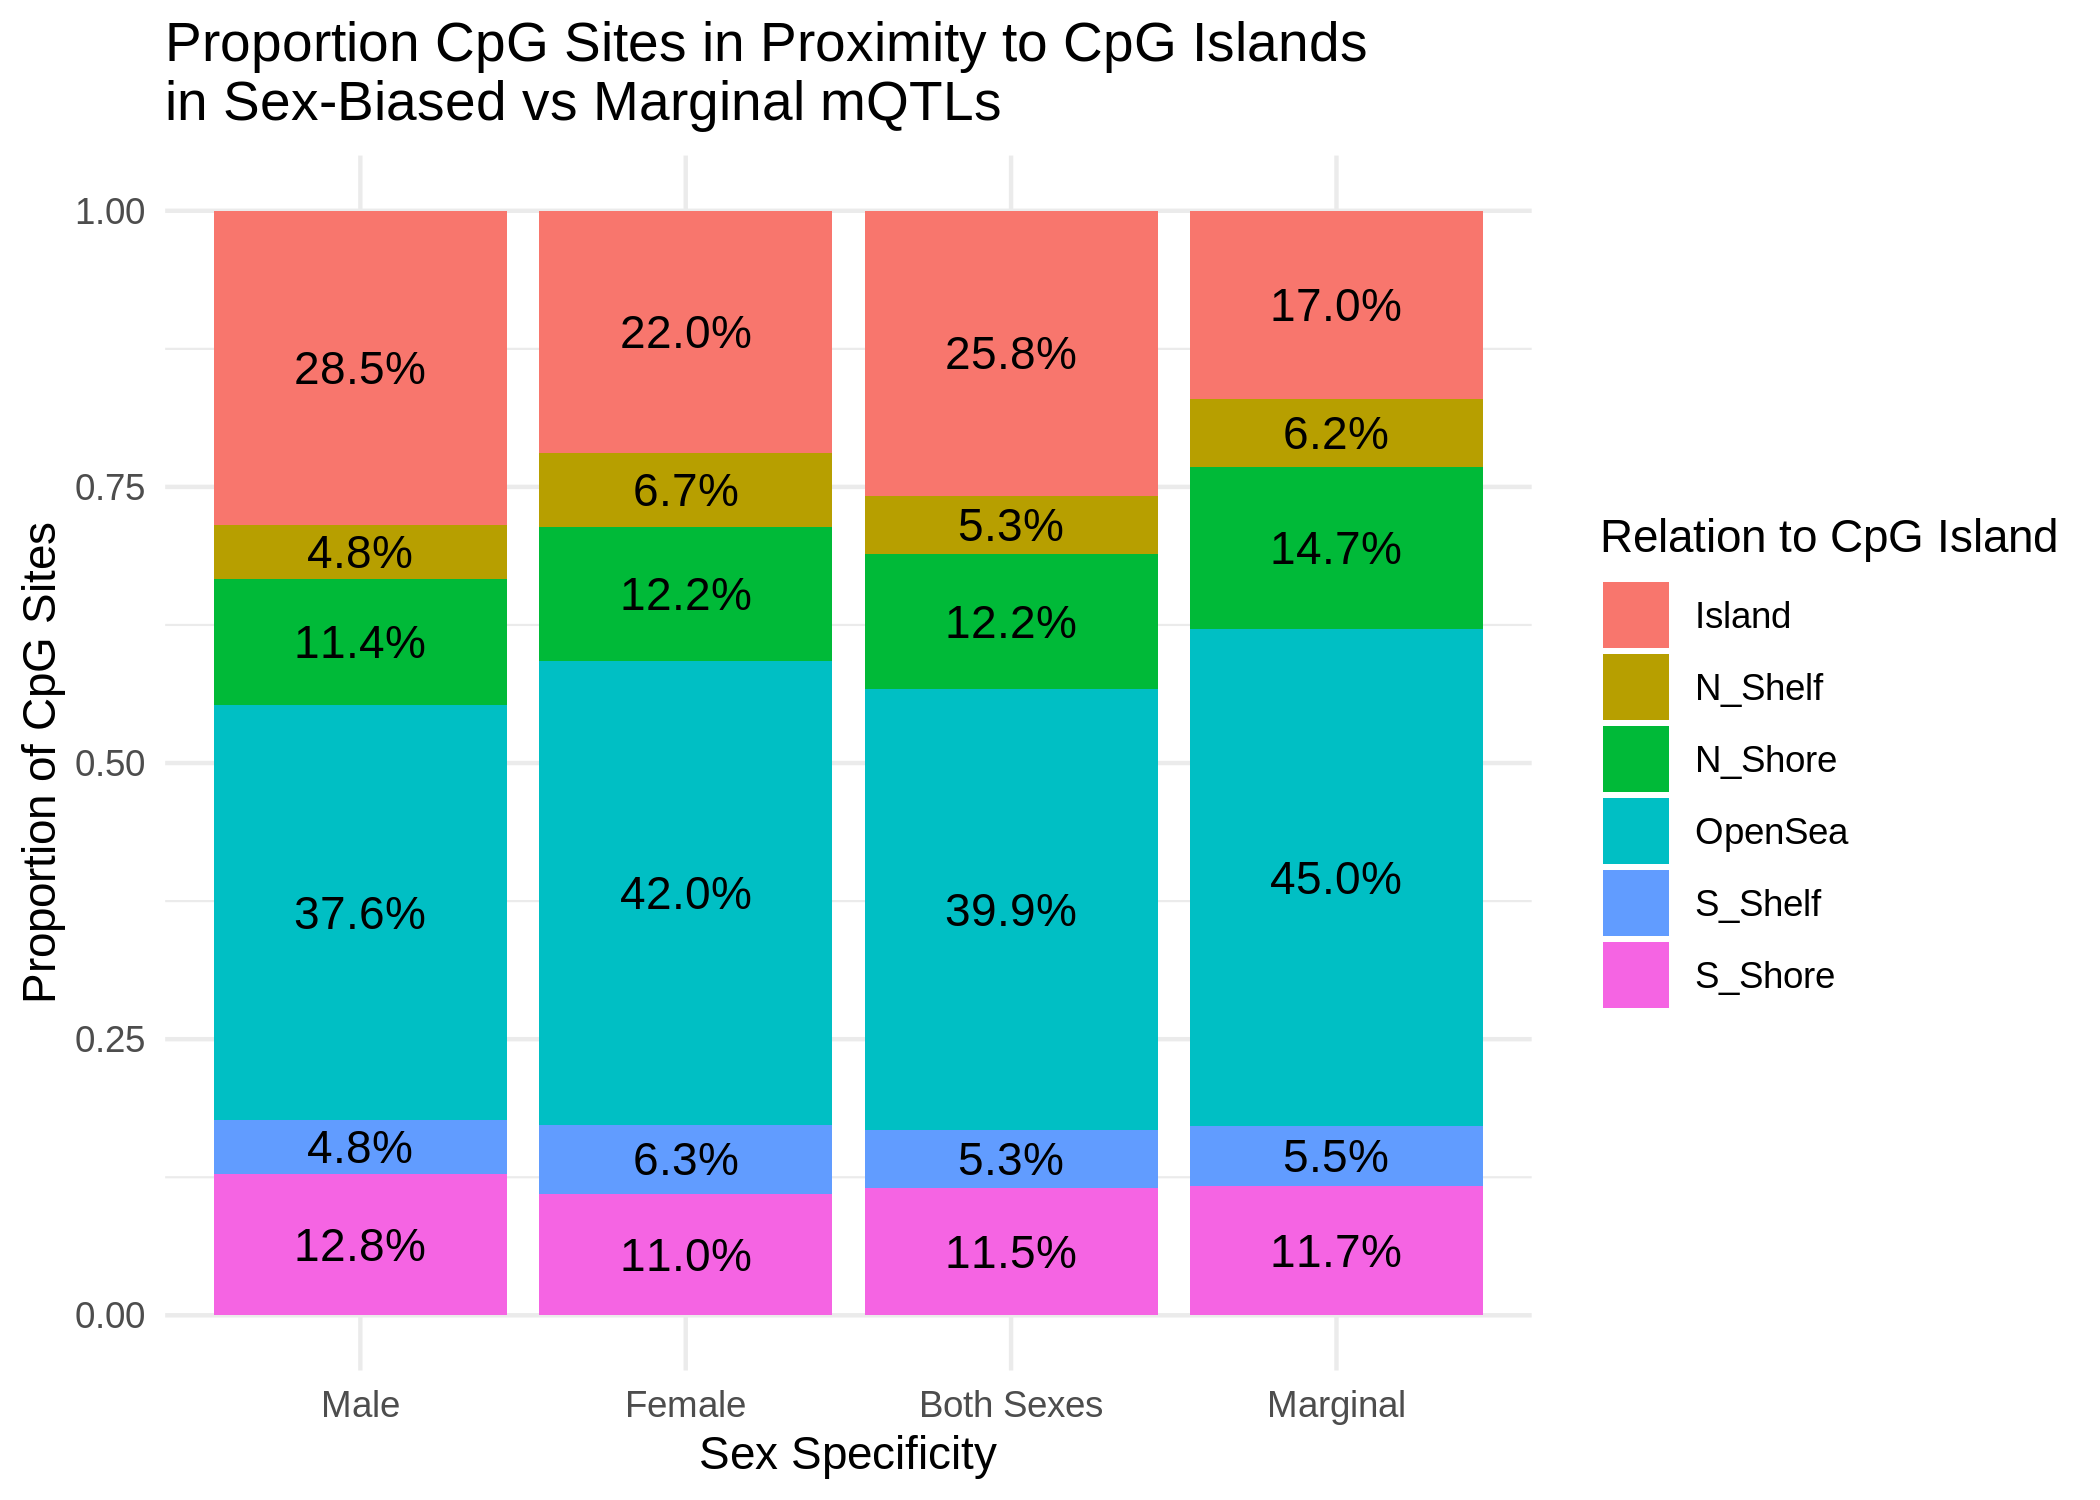

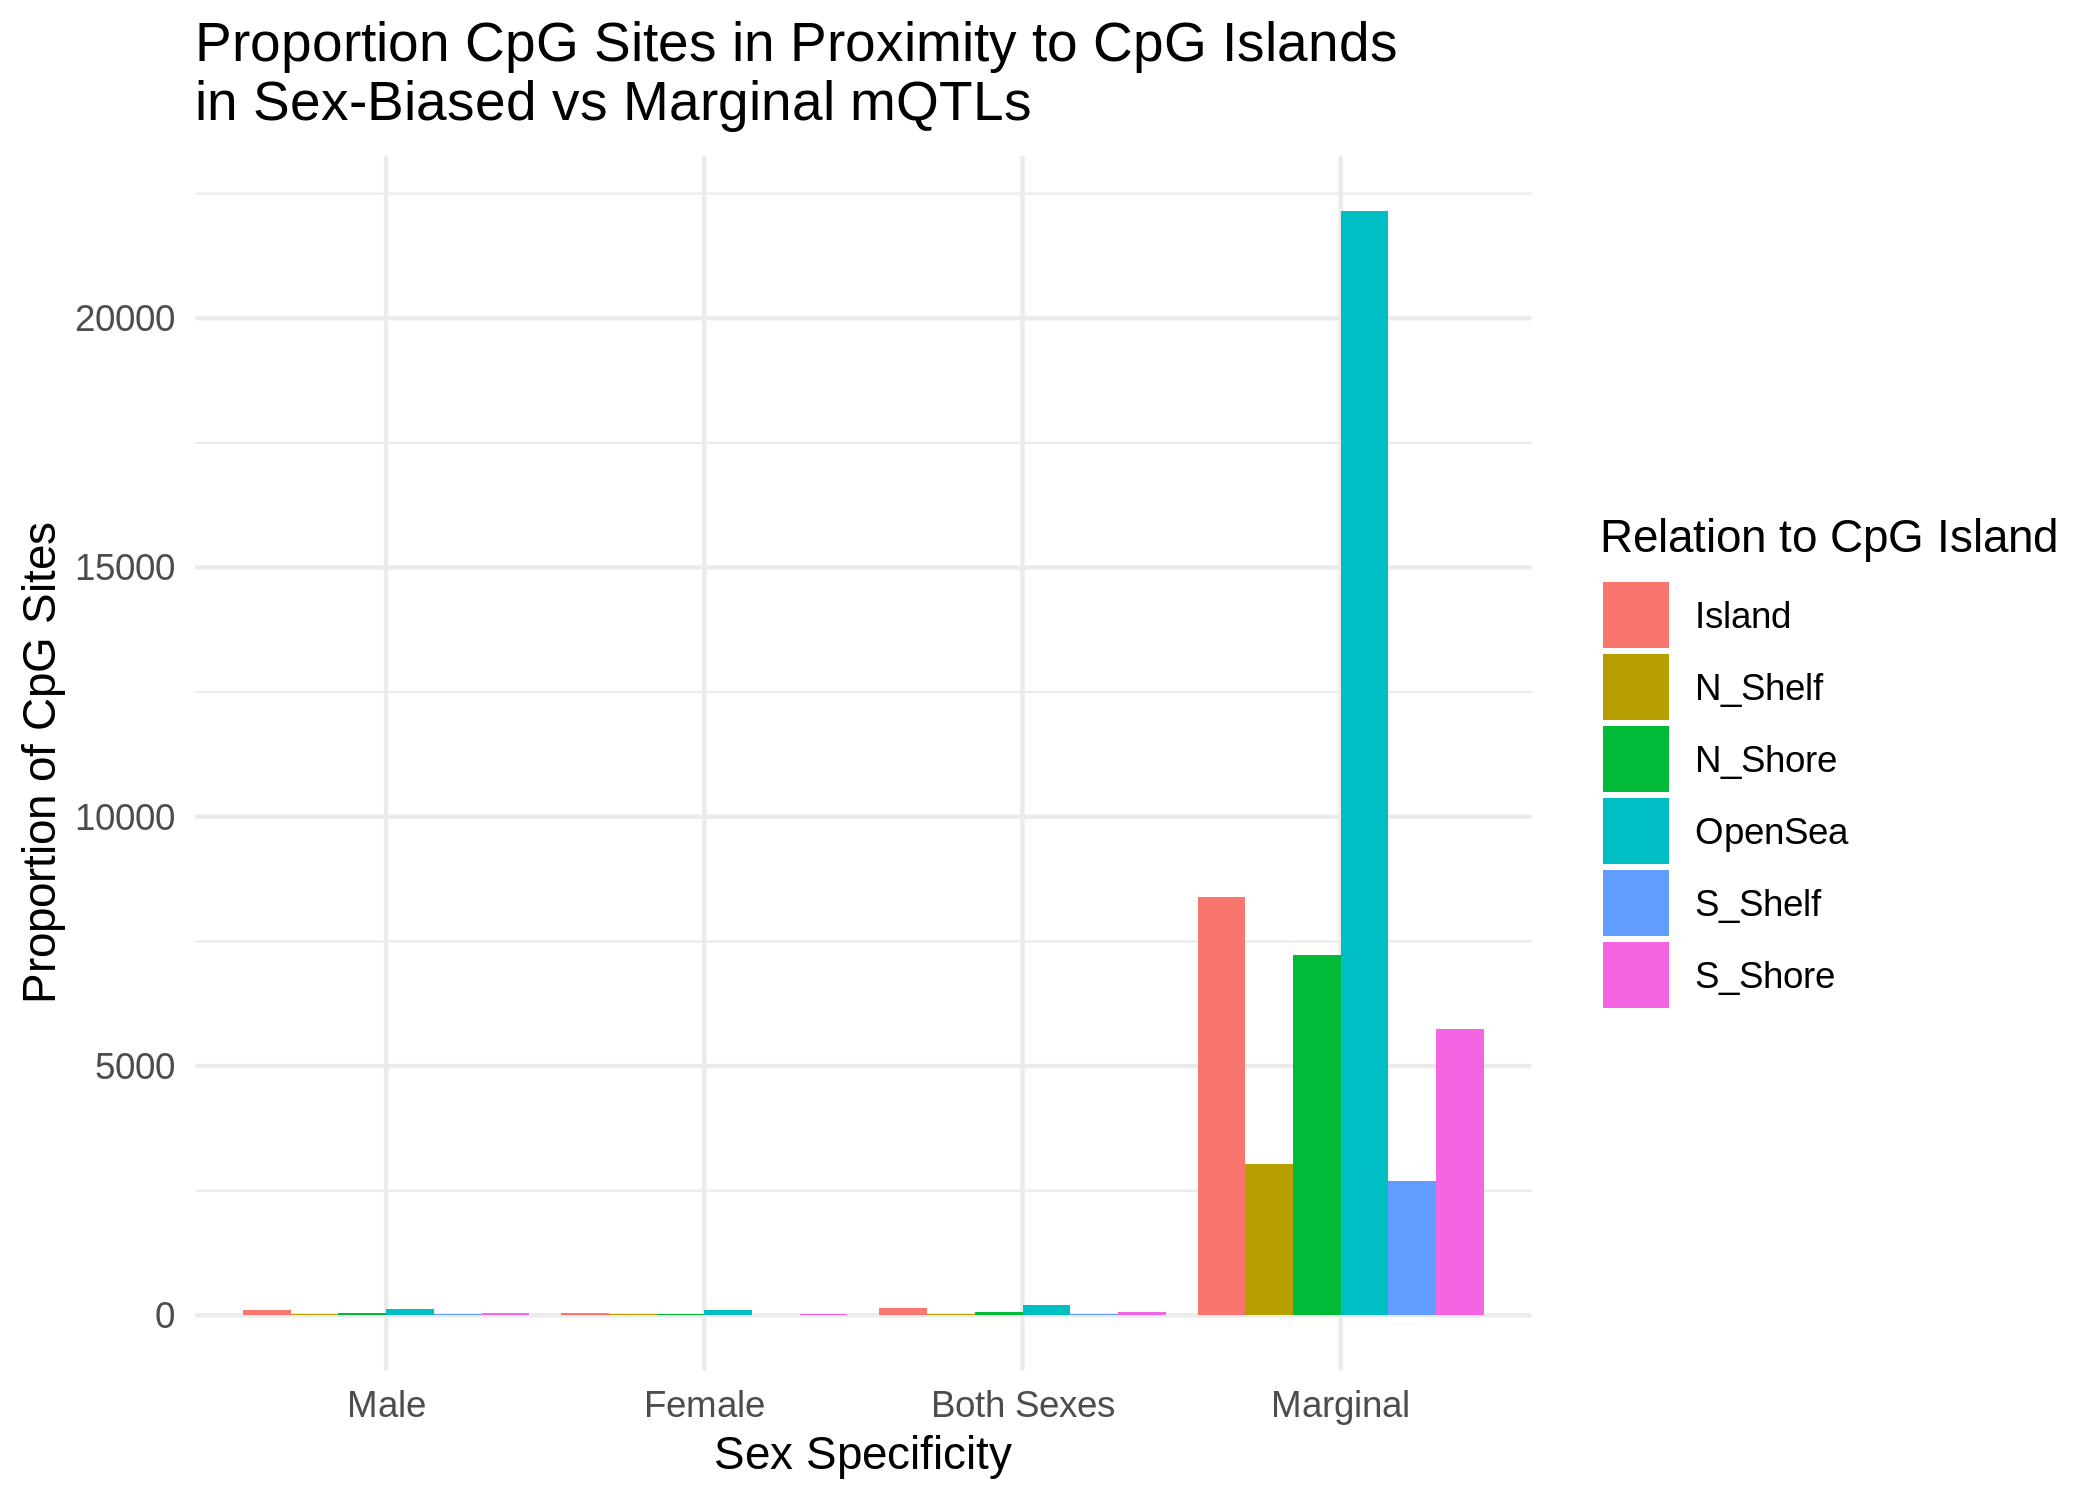

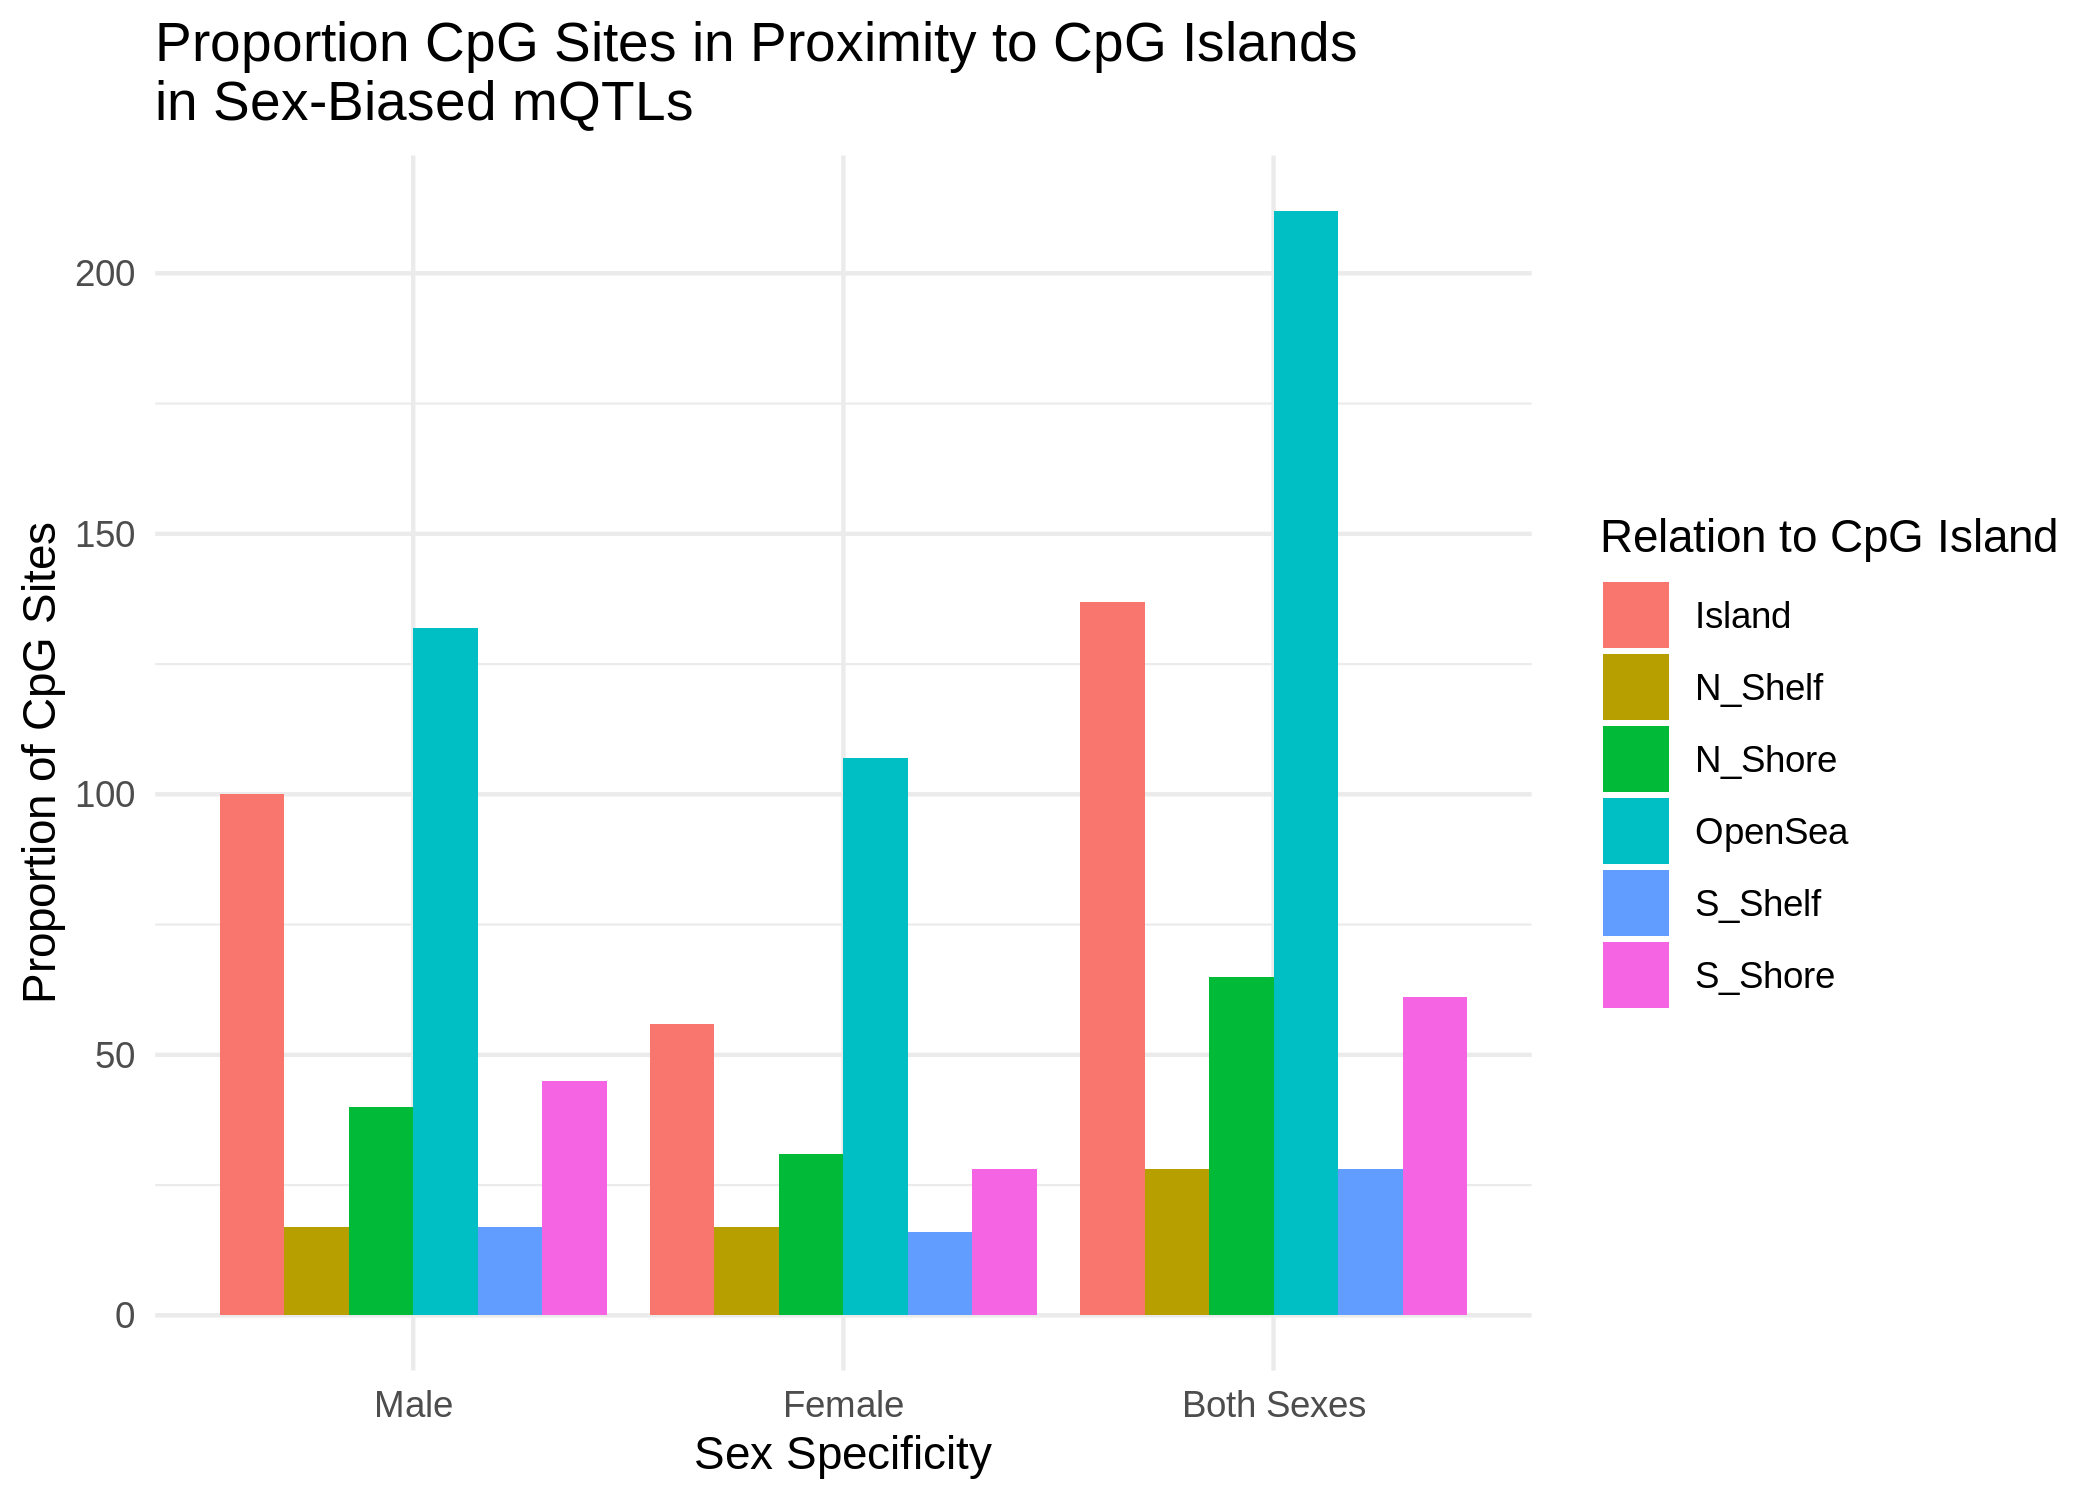

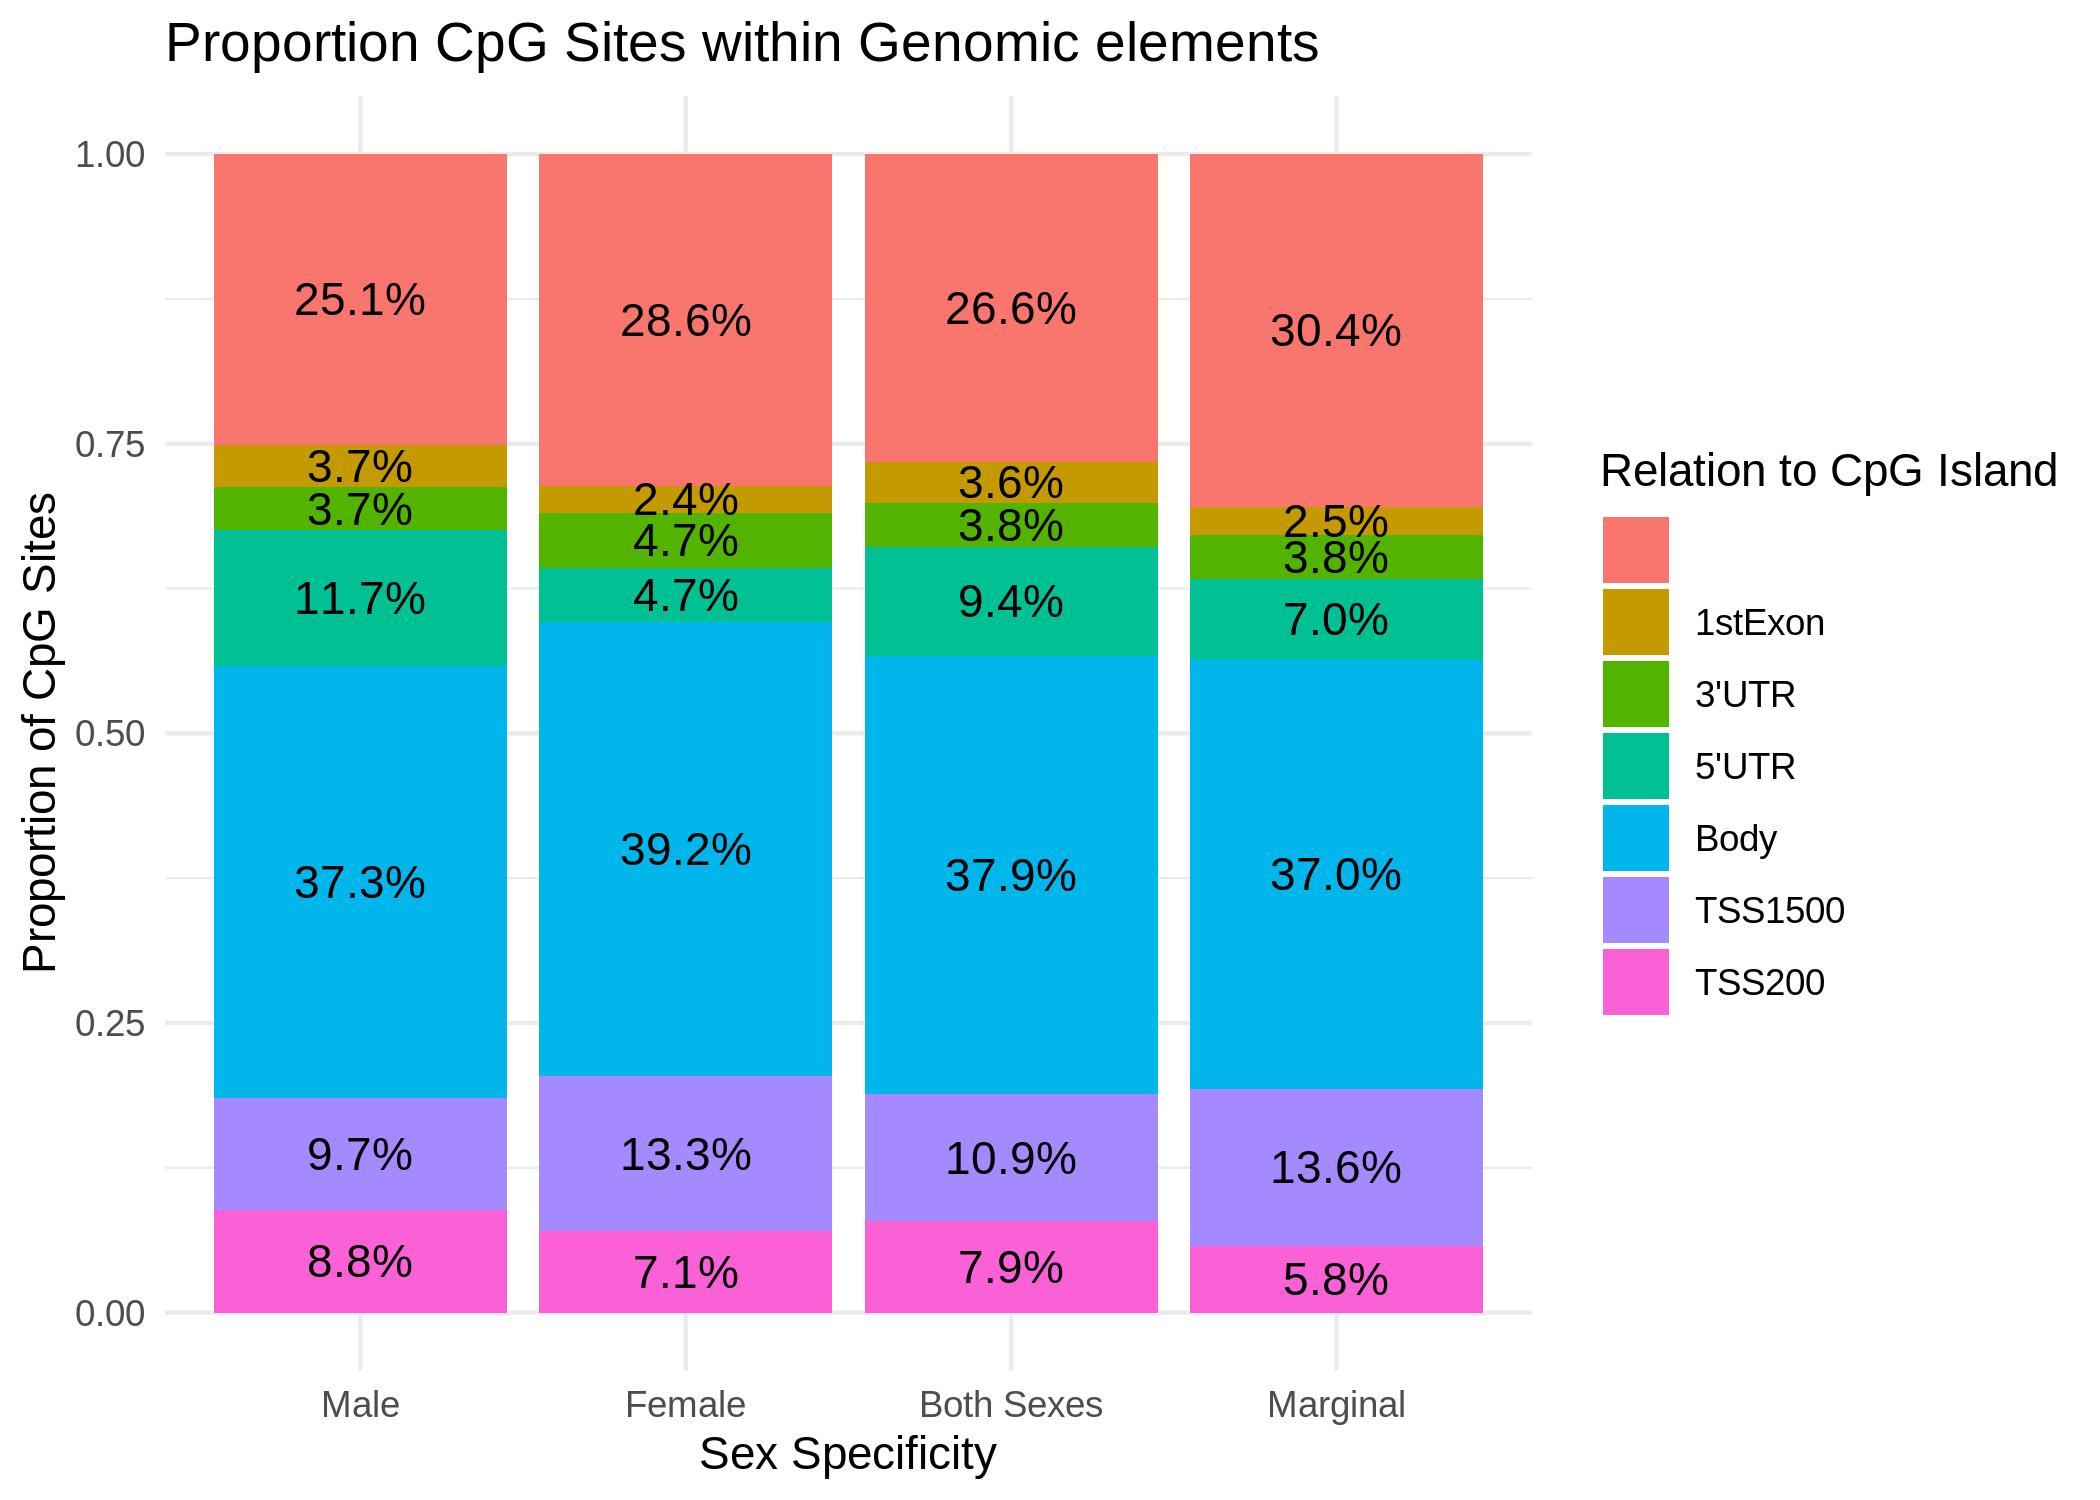

In [11]:
library(GGally)
ggplot(total_annotated[!duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Marginal mQTLs")

ggplot(total_annotated[!duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Marginal mQTLs")

ggplot(total_annotated[Sex != "Marginal" & !duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position="dodge") +
    theme_minimal() +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased mQTLs")
ggplot(total_annotated[!duplicated(total_annotated[,.(Probe,Sex)])], aes(Sex, fill = gsub(";.*","",UCSC_RefGene_Group), by = Sex)) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites within Genomic elements")

In [12]:
fwrite(total_annotated, here("data", "total_annotated.csv.gz"))

## Gene enrichments

In [7]:
total_annotated <- fread(here("data","total_annotated.csv.gz"))
array_genes <- unique(unlist(split(array_annot$UCSC_RefGene_Name,";")))

gtex_med_counts <- fread("/scratch/st-dennisjk-1/wcasazza/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz",skip = 2)[Description %in% array_genes]
sex_genes <- unique(unlist(split(total_annotated[Sex == "Both Sexes"]$UCSC_RefGene_Name,";")))
male_genes <- unique(unlist(split(total_annotated[Sex == "Male"]$UCSC_RefGene_Name,";")))
female_genes <- unique(unlist(split(total_annotated[Sex == "Female"]$UCSC_RefGene_Name,";")))
marginal_genes <- unique(unlist(split(total_annotated[Sex == "Marginal"]$UCSC_RefGene_Name,";")))
gtex_fisher_res <- function(set,tpm_thresh){
    select_genes <- gtex_med_counts[apply(gtex_med_counts[,-c(1,2)] > tpm_thresh,1,all)]$Description
    res <- fisher.test(fisher_mat(set,select_genes,array_genes))
    data.table(
        OR = res$estimate,
        low = res$conf.int[1],
        high = res$conf.int[2],
        P = res$p.value,
        TPM_threshold = tpm_thresh
    )
}

GeneSet,1,2,5,10,15,20
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Marginal,2.801171e-141,8.957350e-91,3.506077e-43,2.106885e-17,2.184716e-07,0.00148849
Sex-biased,4.657044e-05,4.908543e-04,1.600534e-02,8.580003e-01,6.411559e-01,0.77564249
Male,5.003753e-04,1.761274e-03,1.451485e-01,3.840195e-01,2.705662e-01,0.28640489
Female,3.134065e-03,1.510052e-02,1.504233e-02,3.115698e-01,1.000000e+00,0.68330261


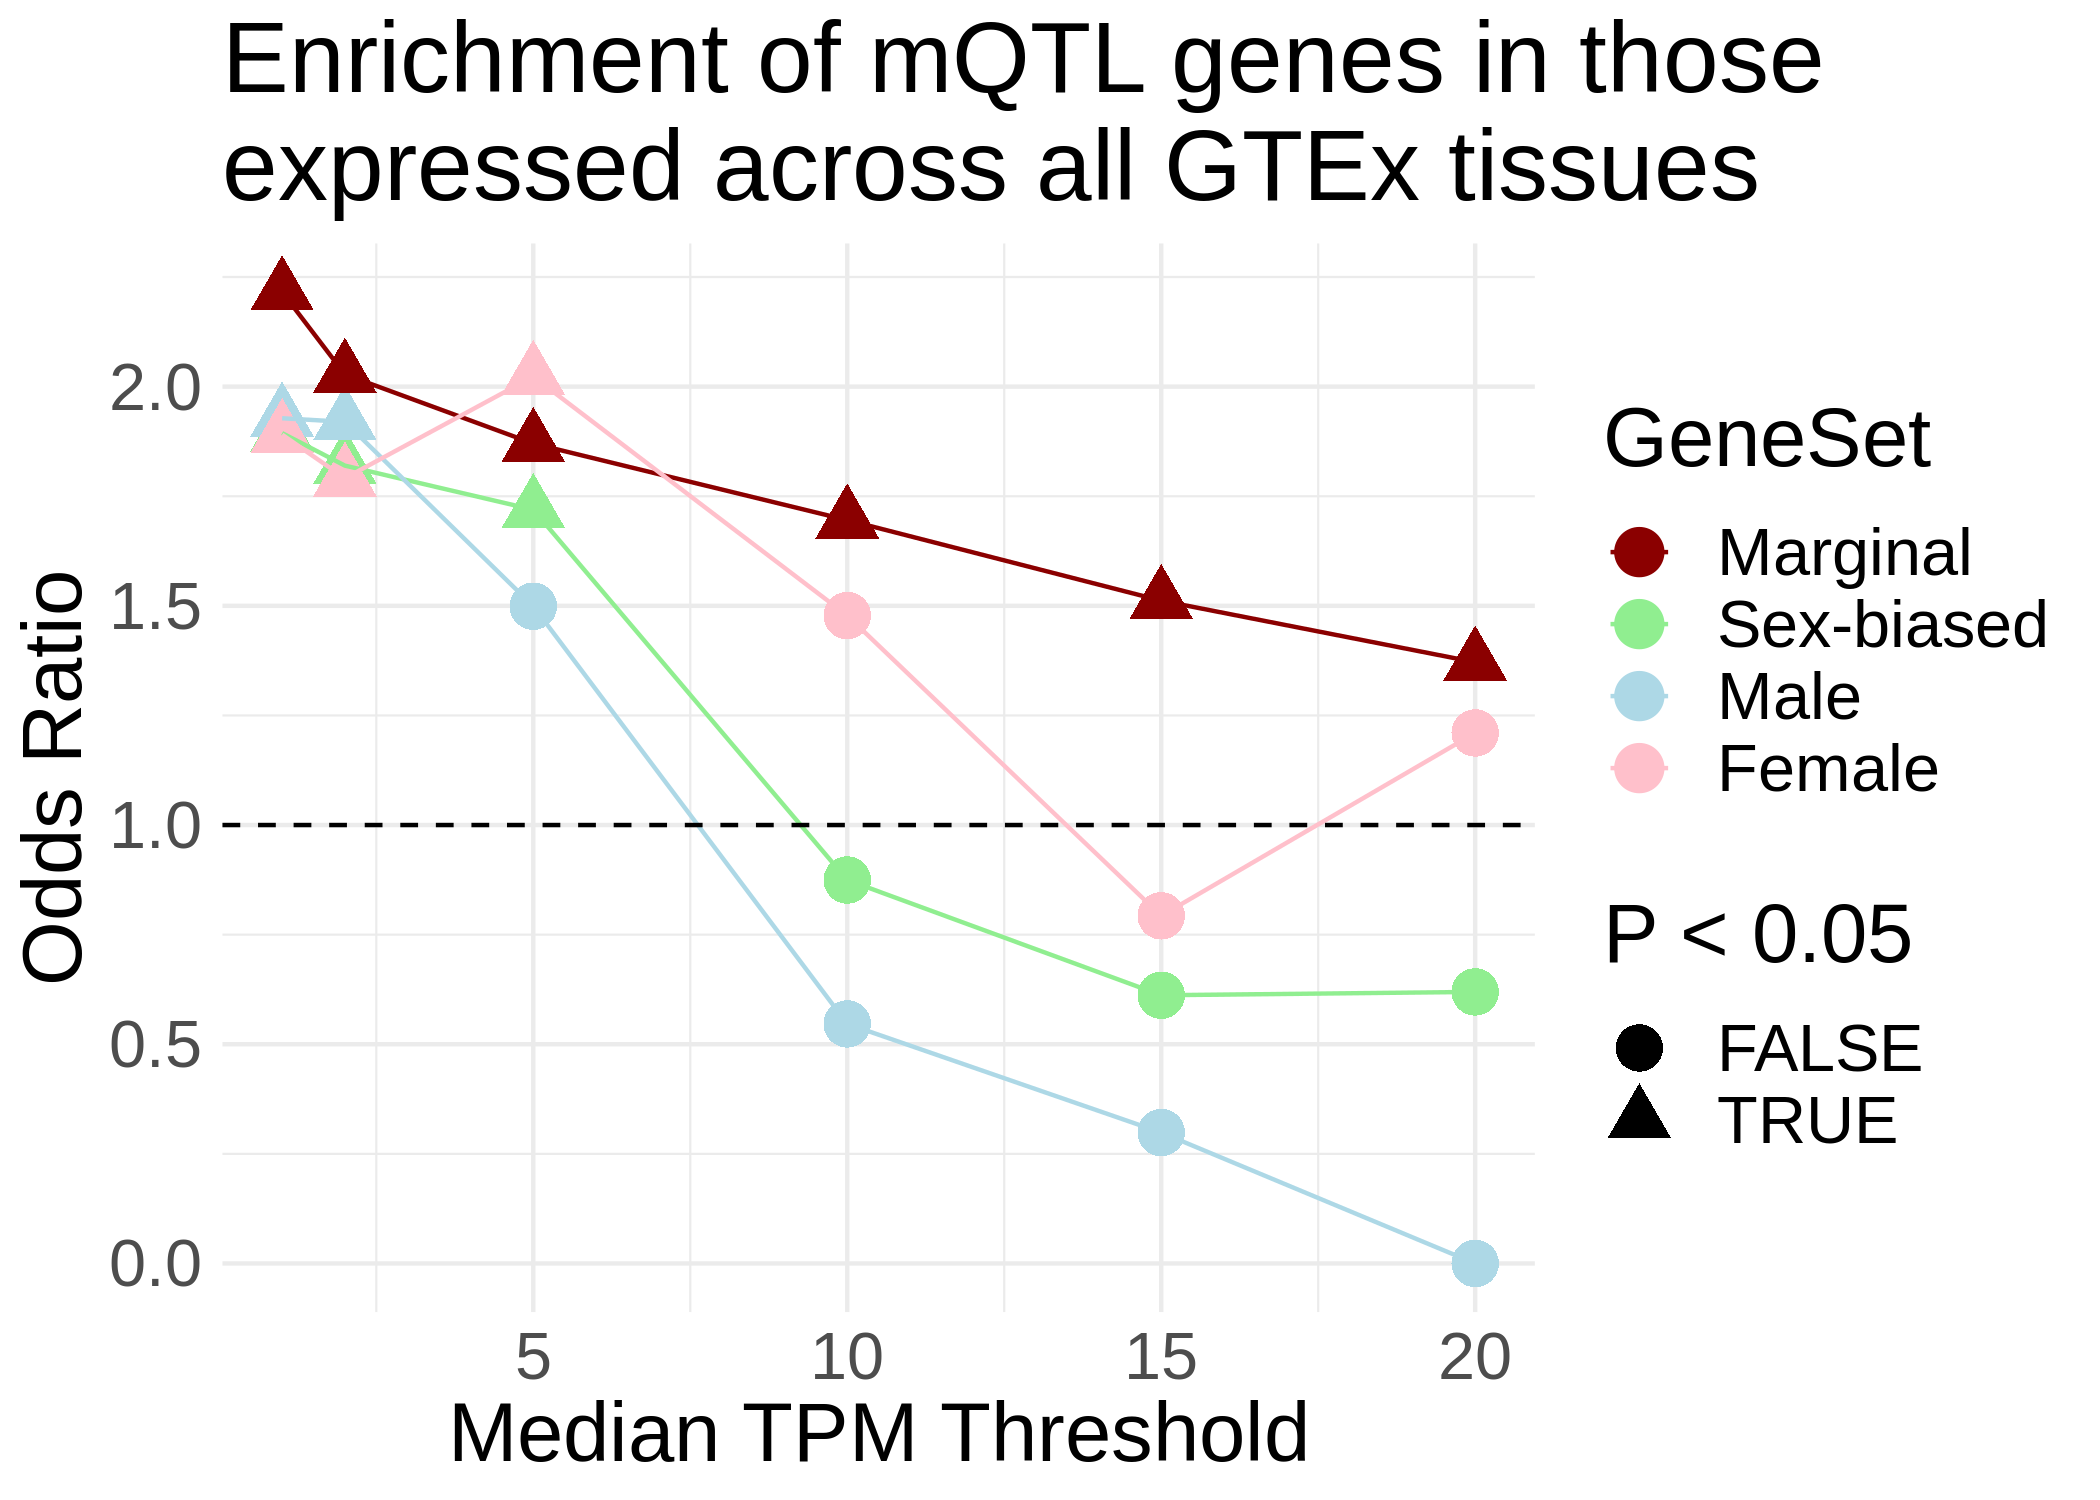

In [16]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)

fisher_mat <- function(set1,set2,background){
    notset1 <- background[!background %in% set1]
    notset2 <- background[!background %in% set2]    
    res <- matrix(
        c(
            length(intersect(set1,set2)),
            length(intersect(notset1,set2)),
            length(intersect(set1,notset2)),
            length(intersect(notset1,notset2))
        ),
        byrow=T,
        nrow = 2
    )
    return(res)
}
res <- rbindlist(lapply(c(1,2,5,10,15,20),function(thresh)rbindlist(lapply(list(`Sex-biased`=sex_genes,Male=male_genes,Female=female_genes,Marginal=marginal_genes),function(x)gtex_fisher_res(x,thresh)),idcol = 'GeneSet')))
res$GeneSet <- factor(res$GeneSet, levels = c("Marginal","Sex-biased","Male","Female"))
p <- ggplot(res,aes(TPM_threshold, color=GeneSet)) +
    geom_point(aes(y=OR,shape = P < 0.05),size=5) +
    geom_line(aes(y=OR))+
    geom_hline(yintercept = 1,linetype='dashed') +
    labs(
        title = "Enrichment of mQTL genes in those\nexpressed across all GTEx tissues",
        x = "Median TPM Threshold",
        y = "Odds Ratio"
    )+
    scale_color_manual(values=c("dark red", "light green",  "light blue", "pink"))+
    theme_minimal() +
    theme(text=element_text(size=20))
print(p)
dcast(res,GeneSet~TPM_threshold,value.var="P")                                                                           

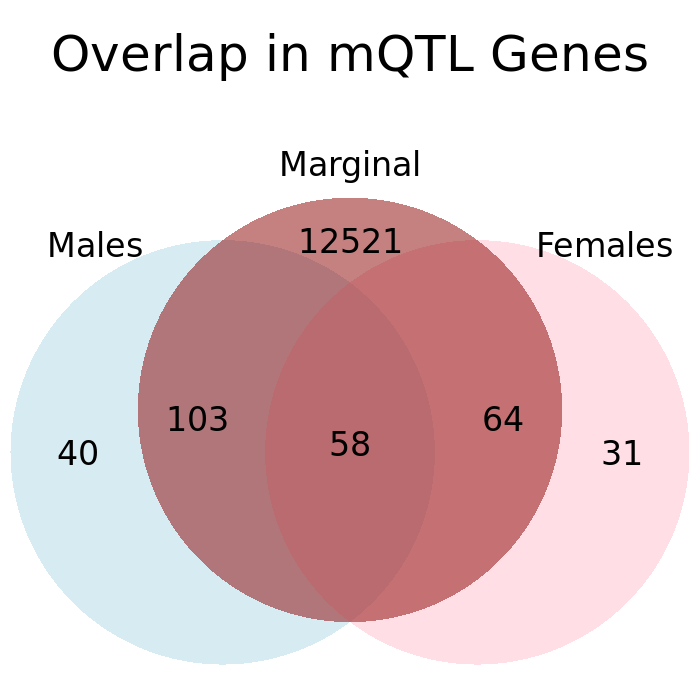

In [54]:
options(repr.plot.width= 7, repr.plot.height= 7, repr.plot.res = 100)
grid.draw(
    venn.diagram(
        list(Males = unique(male_genes), Females = unique(female_genes),Marginal = unique(marginal_genes)),
        filename=NULL,
        fill=c("light blue", "pink","dark red"),
        cat.pos=c(-30,30,0),
        lty = rep("blank",3),
        cex=2,
        cat.cex=2,
        main.cex=3,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in mQTL Genes"
    )
)